<a href="https://colab.research.google.com/github/a-chow3/STAT4996/blob/main/UVA_Baseball_Prediction_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UVA Prediction Models

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Change Working Directory
import os

os.chdir('/content/drive/MyDrive')

In [3]:
import pandas as pd

# Read in UVA Games File
uva_df = pd.read_csv("filtered_uva_games.csv")
uva_df['TaggedPitchType'] = uva_df['TaggedPitchType'].str.replace('ChangeUp', 'Changeup')
uva_df['ExitSpeed'] = uva_df['ExitSpeed'].fillna(0)

# Display the first 5 rows of the DataFrame
uva_df.head()

PitchNo        Date      Time  PAofInning  PitchofPA           Pitcher  \
0        1  2023-02-17  14:08:14           1          1  Edgington, Brian   
1        2  2023-02-17  14:08:35           1          2  Edgington, Brian   
2        3  2023-02-17  14:08:55           1          3  Edgington, Brian   
3        4  2023-02-17  14:09:14           1          4  Edgington, Brian   
4        5  2023-02-17  14:09:35           1          5  Edgington, Brian   

      PitcherId PitcherThrows PitcherTeam       Batter  ...  \
0  1.000027e+09         Right     VIR_CAV  Burch, Nick  ...   
1  1.000027e+09         Right     VIR_CAV  Burch, Nick  ...   
2  1.000027e+09         Right     VIR_CAV  Burch, Nick  ...   
3  1.000027e+09         Right     VIR_CAV  Burch, Nick  ...   
4  1.000027e+09         Right     VIR_CAV  Burch, Nick  ...   

   ThrowTrajectoryZc1 ThrowTrajectoryZc2 PitchReleaseConfidence  \
0                 NaN                NaN                   High   
1                 NaN                NaN                   High   
2                 NaN                NaN                   High   
3                 NaN                NaN                   High   
4                 NaN                NaN                   High   

  PitchLocationConfidence  PitchMovementConfidence HitLaunchConfidence  \
0                    High                     High                 NaN   
1                    High                     High                 NaN   
2                    High                     High                 NaN   
3                    High                     High                 NaN   
4                    High                     High                High   

   HitLandingConfidence  CatcherThrowCatchConfidence  \
0                   NaN                          NaN   
1                   NaN                          NaN   
2                   NaN                          NaN   
3                   NaN                          NaN   
4                  High                          NaN   

   CatcherThrowReleaseConfidence CatcherThrowLocationConfidence  
0                            NaN                            NaN  
1                            NaN                            NaN  
2                            NaN                            NaN  
3                            NaN                            NaN  
4                            NaN                            NaN  

[5 rows x 167 columns]

#### Create Standardized Statistic (PES)

In [4]:
# Define Outcomes based on Run Value (Scaled up by 10 for interpretability)
def get_pitch_outcome_adjustment(row):
    adjustment = 0

    if row['PitchCall'] == 'StrikeSwinging':
        adjustment += 2.1  # Base value for a swinging strike
        if row['KorBB'] == 'Strikeout':
            adjustment += 2.7  # Additional value for completing the strikeout
    elif row['PitchCall'] == 'StrikeCalled':
        adjustment += 1.4  # Base value for a called strike
        if row['KorBB'] == 'Strikeout':
            adjustment += 2.7  # Additional value for completing the strikeout
    elif row['PitchCall'] == 'FoulBall':
        adjustment += 0.9  # Foul balls
    elif row['PitchCall'] == 'Ball':
        adjustment -= 1.0  # Base negative value for a ball
        if row['KorBB'] == 'Walk':
            adjustment -= 3.7  # Additional negative value for completing the walk
    elif row['PitchCall'] == 'HitByPitch':
        adjustment -= 3.7  # Hit by pitch (treated similarly to a walk)
    elif row['PitchCall'] == 'InPlay':
        if row['PlayResult'] == 'Out':
            adjustment += 2.7  # Out
        elif row['PlayResult'] == 'Single':
            adjustment -= 4.7  # Single
        elif row['PlayResult'] == 'Double':
            adjustment -= 7.8  # Double
        elif row['PlayResult'] == 'Triple':
            adjustment -= 10.2  # Triple
        elif row['PlayResult'] == 'HomeRun':
            adjustment -= 14.0  # Home run

    return adjustment

def get_exit_velocity_adjustment(row):
    if row['ExitSpeed'] < 80:
        return 2.0  # Weak contact
    elif row['ExitSpeed'] >= 95:
        return -0.5  # Hard contact
    return 0

In [5]:
def calculate_pes(row):
    base_score = 100
    pitch_outcome_adj = get_pitch_outcome_adjustment(row)
    exit_velocity_adj = get_exit_velocity_adjustment(row)

    return base_score + pitch_outcome_adj + exit_velocity_adj

uva_df['PES'] = uva_df.apply(calculate_pes, axis=1)

# Mean and SD
league_average_pes = uva_df['PES'].mean()
league_average_pes_sd = uva_df['PES'].std()

# Add Standardized Values to New Column
uva_df['StandardizedPES'] = 100 + (uva_df['PES'] - league_average_pes)
uva_df['StandardizedPES'] = uva_df['StandardizedPES'].round(2)

print(f"League Average PES: {league_average_pes}")

print(f"League Average PES SD: {league_average_pes_sd}")

League Average PES: 102.32754363558962
League Average PES SD: 2.7844946634884185


## Add Statistical Columns


In [6]:
import numpy as np

# On-base events
uva_df['OBP'] = np.where(
    (uva_df['PlayResult'].isin(['Single', 'Double', 'Triple', 'HomeRun'])) |
    (uva_df['PitchCall'] == 'HitByPitch') |
    (uva_df['PitchCall'] == 'BallCalled') & (uva_df['Balls'] == 3),
    1, 0
)


# Total bases
uva_df['TB'] = np.select(
    [
        uva_df['PlayResult'].isin(['Undefined', 'Out', 'Error, FieldersChoice',
                                   'Sacrifice', 'StolenBase', 'CaughtStealing']),
        uva_df['PlayResult'] == 'Single',
        uva_df['PlayResult'] == 'Double',
        uva_df['PlayResult'] == 'Triple',
        uva_df['PlayResult'] == 'HomeRun'
    ],
    [0, 1, 2, 3, 4],
    default=0
)

# Now calculate RC
uva_df['RC'] = uva_df['OBP'] * uva_df['TB']

### Predicting RC

In [7]:
# Create differnet Subsets based on different Matchups and Pitch Types

# Define unique values for each categorical column
pitcher_throws_values = uva_df['PitcherThrows'].unique()
batter_side_values = uva_df['BatterSide'].unique()
tagged_pitch_type_values = uva_df['TaggedPitchType'].unique()

# Create an empty dictionary to store the subset DataFrames
subset_dfs = {}

# Iterate through all combinations of categorical values
for pitcher_throws in pitcher_throws_values:
    for batter_side in batter_side_values:
        for tagged_pitch_type in tagged_pitch_type_values:
            # Create a DataFrame name based on the combination
            df_name = f"{pitcher_throws[0]}{batter_side[0]}_{tagged_pitch_type}"

            # Filter the original DataFrame to create the subset
            subset_dfs[df_name] = uva_df[
                (uva_df['PitcherThrows'] == pitcher_throws) &
                (uva_df['BatterSide'] == batter_side) &
                (uva_df['TaggedPitchType'] == tagged_pitch_type)
            ]


In [8]:
pitch_types = ['Fastball', 'Slider', 'Splitter', 'Changeup', 'Curveball', 'Undefined', 'Cutter', 'Sinker']
handedness = ['RR', 'RL', 'LR', 'LL']

for hand in handedness:
    for pitch in pitch_types:
        key = f"{hand}_{pitch}"
        if key in subset_dfs:
            shape = subset_dfs[key].shape
            print(f"Shape of {key}: {shape}")
        else:
            print(f"{key} not found in the dictionary")

Shape of RR_Fastball: (435, 172)
Shape of RR_Slider: (262, 172)
Shape of RR_Splitter: (26, 172)
Shape of RR_Changeup: (56, 172)
Shape of RR_Curveball: (87, 172)
Shape of RR_Undefined: (73, 172)
Shape of RR_Cutter: (32, 172)
Shape of RR_Sinker: (53, 172)
Shape of RL_Fastball: (359, 172)
Shape of RL_Slider: (58, 172)
Shape of RL_Splitter: (19, 172)
Shape of RL_Changeup: (177, 172)
Shape of RL_Curveball: (30, 172)
Shape of RL_Undefined: (58, 172)
Shape of RL_Cutter: (0, 172)
Shape of RL_Sinker: (62, 172)
Shape of LR_Fastball: (230, 172)
Shape of LR_Slider: (19, 172)
Shape of LR_Splitter: (0, 172)
Shape of LR_Changeup: (108, 172)
Shape of LR_Curveball: (20, 172)
Shape of LR_Undefined: (32, 172)
Shape of LR_Cutter: (0, 172)
Shape of LR_Sinker: (0, 172)
Shape of LL_Fastball: (65, 172)
Shape of LL_Slider: (54, 172)
Shape of LL_Splitter: (0, 172)
Shape of LL_Changeup: (1, 172)
Shape of LL_Curveball: (18, 172)
Shape of LL_Undefined: (15, 172)
Shape of LL_Cutter: (0, 172)
Shape of LL_Sinker: (0,

In [9]:
# Cut down the List of subset_dfs to only include dfs with 15 or more rows
subset_dfs = {key: df for key, df in subset_dfs.items() if df.shape[0] >= 20}

# Cut down RR_Undefined, RL_Undefined, LR_Undefined, LL_Undefined
for key in ['RR_Undefined', 'RL_Undefined', 'LR_Undefined', 'LL_Undefined']:
    if key in subset_dfs:
        del subset_dfs[key]

In [10]:
# Cut down columns to only include numeric columns for analysis
for df_name, df in subset_dfs.items():
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    subset_dfs[df_name] = df[numeric_cols]

In [11]:
# Keep only Selected Columns
desired_columns = [
    'Balls', 'Strikes', 'RelSpeed', 'VertRelAngle', 'SpinRate', 'SpinAxis',
    'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak',
    'PlateLocHeight', 'PlateLocSide', 'VertApprAngle', 'HorzApprAngle',
    'ExitSpeed', 'RC', 'StandardizedPES' # Change Depending on model chosen
]

for df_name, df in subset_dfs.items():
    # Select only the desired columns that exist in the DataFrame
    existing_columns = [col for col in desired_columns if col in df.columns]

    # Keep only these columns in the DataFrame
    subset_dfs[df_name] = df[existing_columns]

### Runs Created Random Forest Model


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Iterate through subset DataFrames
for df_name, df in subset_dfs.items():
    # Check if the DataFrame is not empty
    if not df.empty:

        # Prepare data for the model
        X = df.drop('RC', axis=1)  # Features (all columns except RC)
        y = df['RC']  # Target variable (RC)

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create and train the Random Forest model
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)

        # Make predictions on the testing set
        y_pred = model.predict(X_test)

        # Evaluate the model's performance
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
        feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

        print(f"Results for {df_name}:")
        print(f"Mean Squared Error: {mse}")
        print(f"R-squared: {r2}")
        print(f"Important Features: {feature_importance}")
        print("-" * 20)  # Print a separator between results
    else:
        print(f"DataFrame {df_name} is empty. Skipping...")

Results for RR_Fastball:
Mean Squared Error: 0.004691954022988509
R-squared: 0.984505497382199
Important Features:              Feature  Importance
16   StandardizedPES    0.962845
7            RelSide    0.007203
13     VertApprAngle    0.005236
0              Balls    0.005222
6          RelHeight    0.002997
5           SpinAxis    0.002774
15         ExitSpeed    0.002531
9   InducedVertBreak    0.002311
4           SpinRate    0.001990
2           RelSpeed    0.001396
11    PlateLocHeight    0.001258
8          Extension    0.001194
10         HorzBreak    0.001182
1            Strikes    0.000768
14     HorzApprAngle    0.000576
12      PlateLocSide    0.000459
3       VertRelAngle    0.000060
--------------------
Results for RR_Slider:
Mean Squared Error: 0.23052452830188677
R-squared: 0.6265608996539793
Important Features:              Feature  Importance
16   StandardizedPES    0.923940
15         ExitSpeed    0.016332
14     HorzApprAngle    0.014593
3       VertRelAngle    0

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering  # Import for clustering

# Function to perform hierarchical clustering and plot scatterplot
def perform_hierarchical_clustering(df, feature, name):
    # Select the top feature and RC
    data = df[[feature, 'RC']]

    # Replace infinite values with NaN
    data = data.replace([np.inf, -np.inf], np.nan)

    # Drop rows with NaN values
    data = data.dropna()

    # Standardize the features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Perform hierarchical clustering
    n_clusters = 3  # You can adjust the number of clusters
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    clusters = clustering.fit_predict(data_scaled)

    # Plot the scatterplot
    plt.figure(figsize=(10, 7))
    plt.scatter(data[feature], data['RC'], c=clusters, cmap='viridis')
    plt.title(f'Hierarchical Clustering Scatterplot for {name}\nFeatures: {feature} and RC')
    plt.xlabel(feature)
    plt.ylabel('RC')
    plt.savefig(f'scatterplot_{name}.png')  # Save the plot as PNG
    plt.close()

# Iterate through subset DataFrames
for df_name, df in subset_dfs.items():
    # Check if the DataFrame is not empty and has at least 2 samples
    if not df.empty and len(df) >= 2:
        print(f"Processing {df_name}...")

        # Prepare data for the model
        X = df.drop('RC', axis=1)  # Features (all columns except RC)
        y = df['RC']  # Target variable (RC)

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create and train the Random Forest model
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)

        # Get feature importances
        feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
        feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

        # Get the top feature
        top_feature = feature_importance.iloc[0]['Feature']

        # Perform hierarchical clustering
        perform_hierarchical_clustering(df, top_feature, df_name)

        print(f"Clustering completed for {df_name}. Scatterplot saved as scatterplot_{df_name}.png")
        print("-" * 20)  # Print a separator between results
    else:
        print(f"DataFrame {df_name} is empty or has insufficient samples. Skipping...")

Processing RR_Fastball...
Clustering completed for RR_Fastball. Scatterplot saved as scatterplot_RR_Fastball.png
--------------------
Processing RR_Slider...
Clustering completed for RR_Slider. Scatterplot saved as scatterplot_RR_Slider.png
--------------------
Processing RR_Splitter...
Clustering completed for RR_Splitter. Scatterplot saved as scatterplot_RR_Splitter.png
--------------------
Processing RR_Changeup...
Clustering completed for RR_Changeup. Scatterplot saved as scatterplot_RR_Changeup.png
--------------------
Processing RR_Curveball...
Clustering completed for RR_Curveball. Scatterplot saved as scatterplot_RR_Curveball.png
--------------------
Processing RR_Cutter...
Clustering completed for RR_Cutter. Scatterplot saved as scatterplot_RR_Cutter.png
--------------------
Processing RR_Sinker...
Clustering completed for RR_Sinker. Scatterplot saved as scatterplot_RR_Sinker.png
--------------------
Processing RL_Fastball...
Clustering completed for RL_Fastball. Scatterplot s

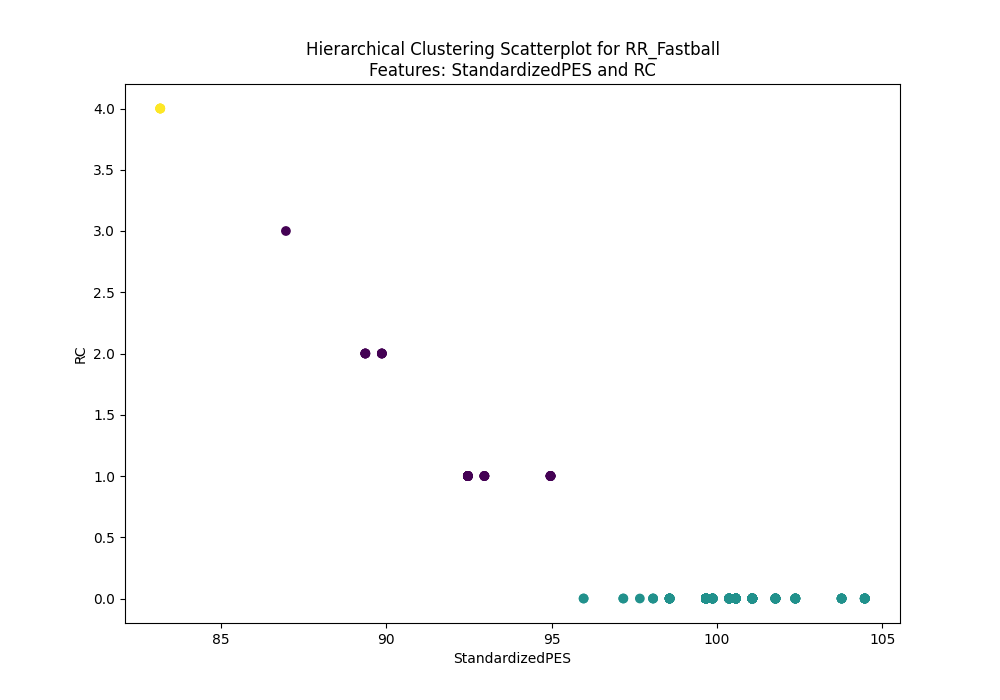

Scatterplot for RR_Fastball


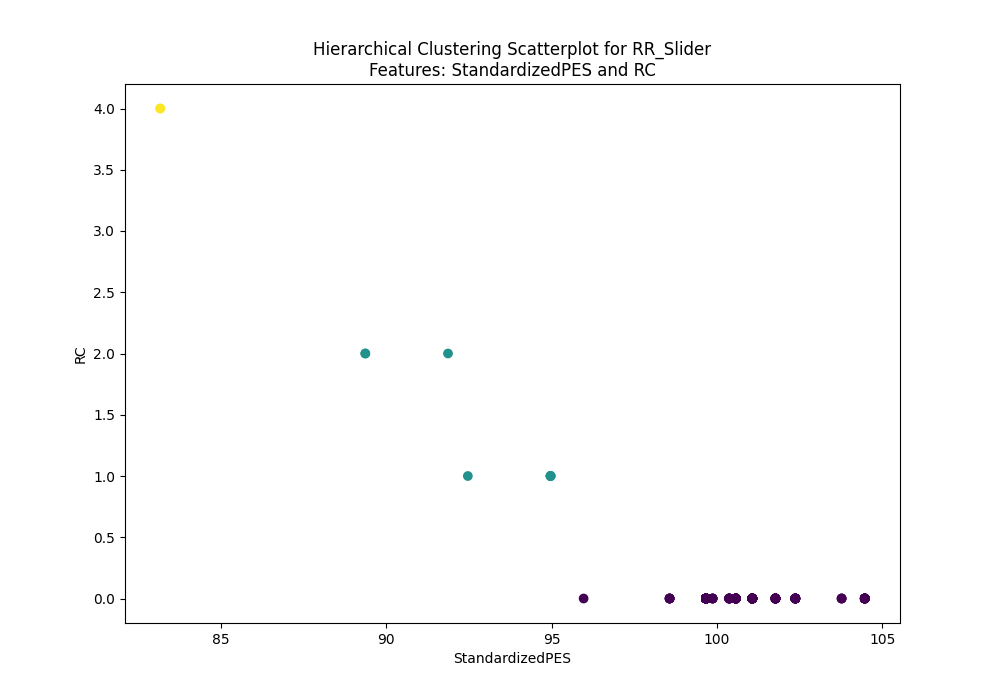

Scatterplot for RR_Slider


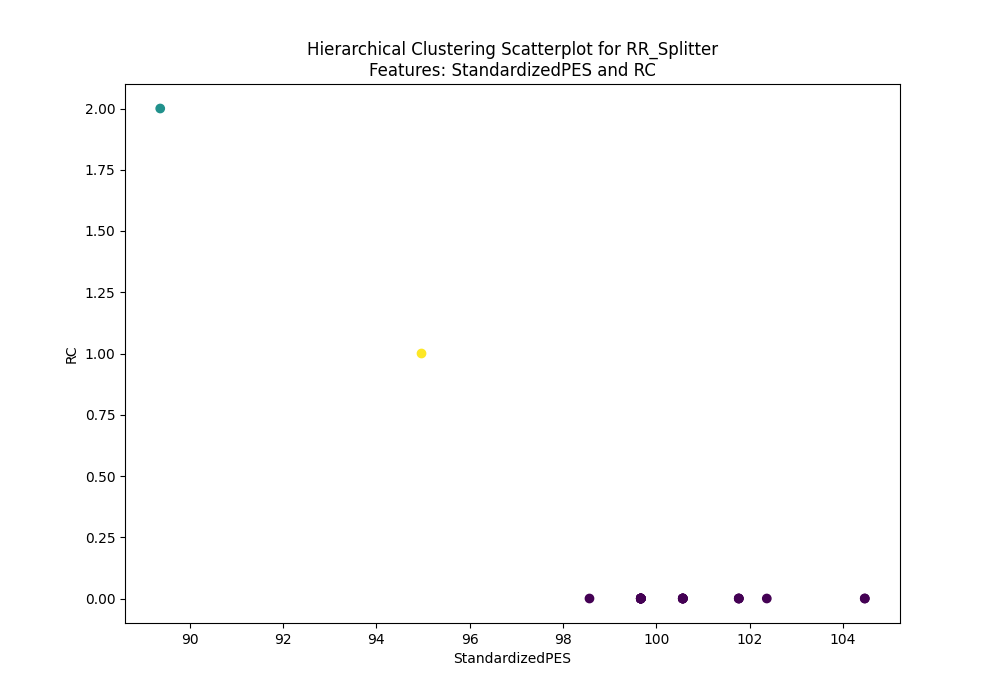

Scatterplot for RR_Splitter


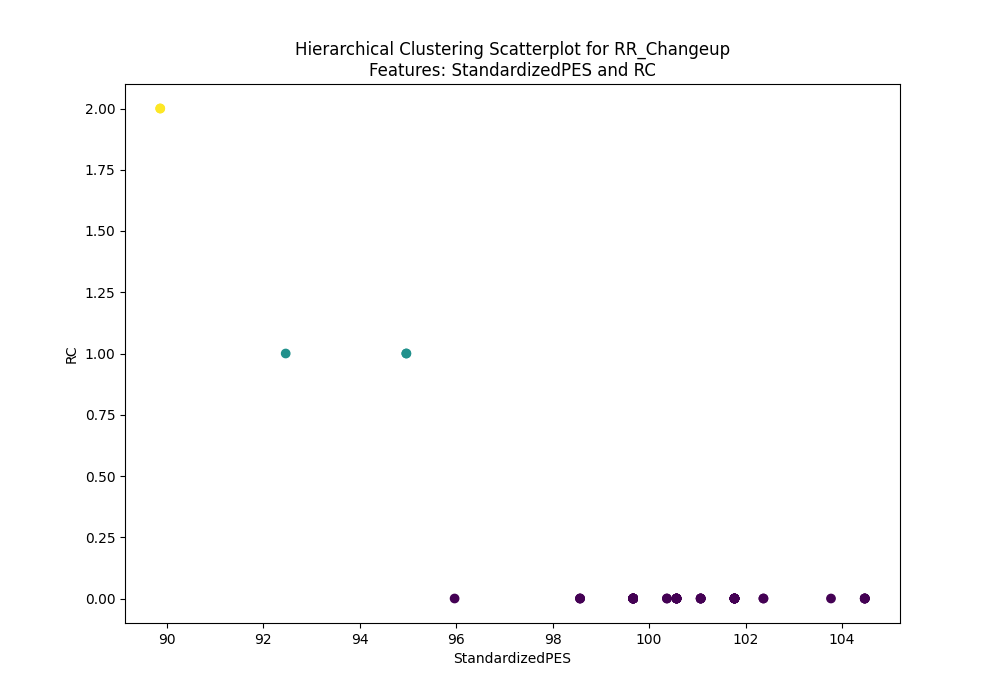

Scatterplot for RR_Changeup


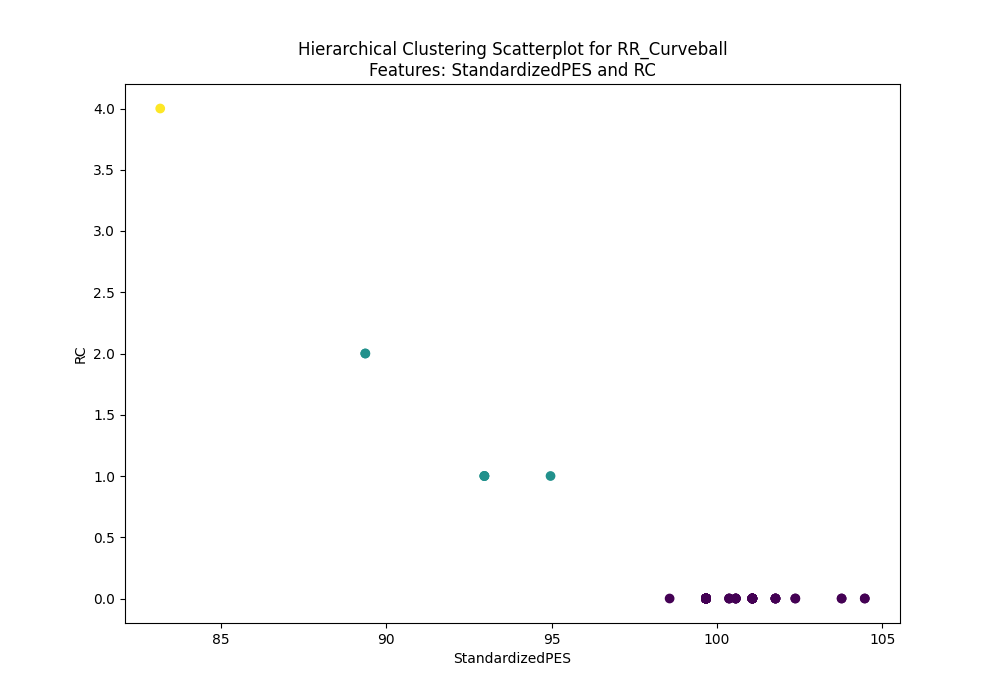

Scatterplot for RR_Curveball


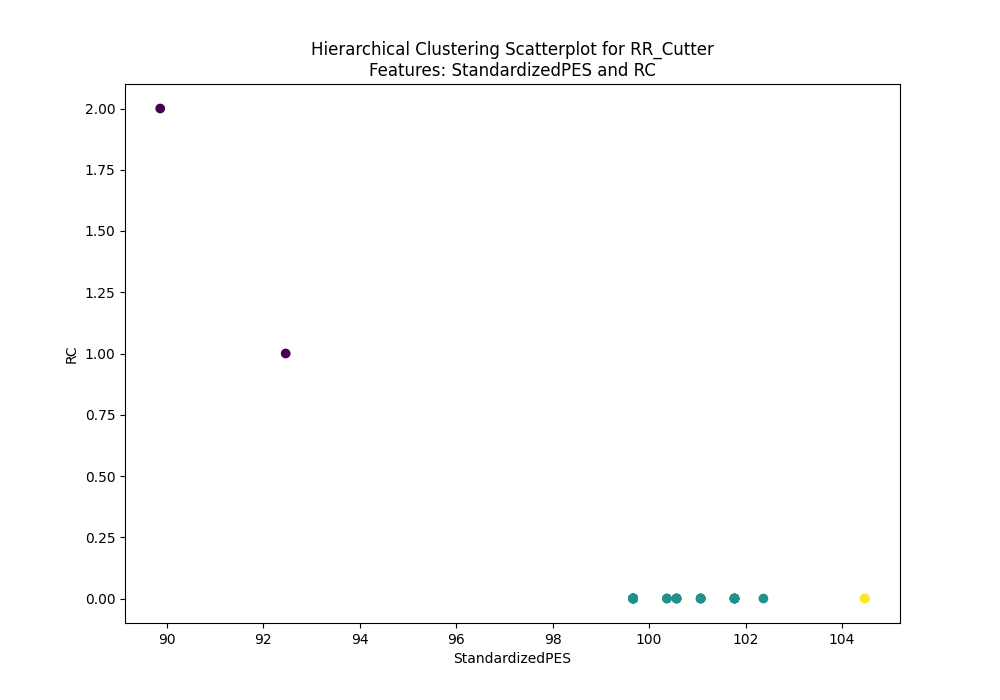

Scatterplot for RR_Cutter


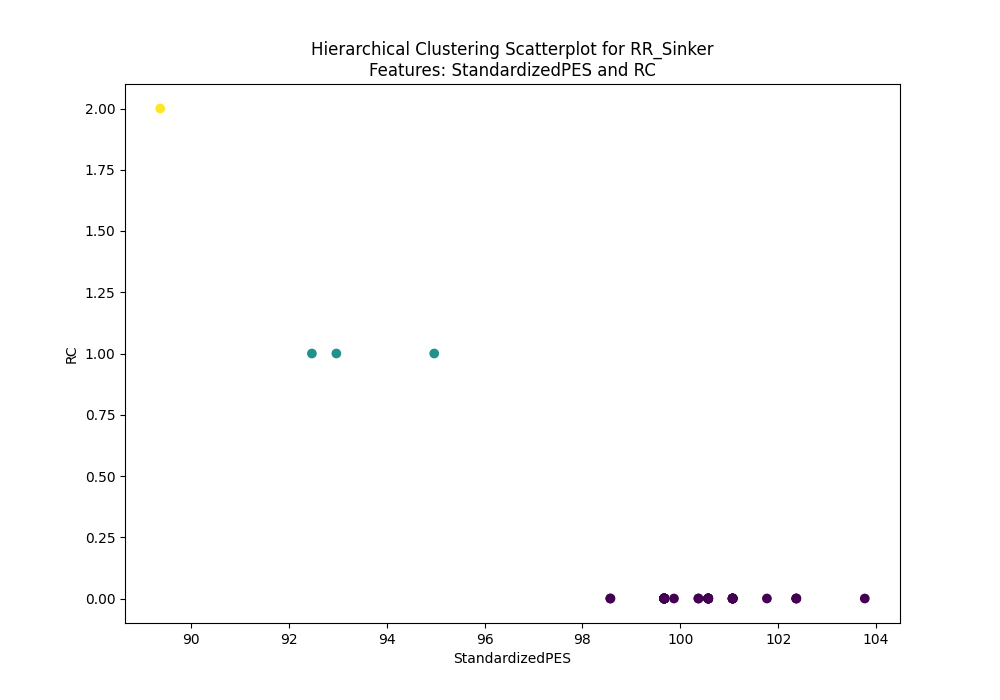

Scatterplot for RR_Sinker


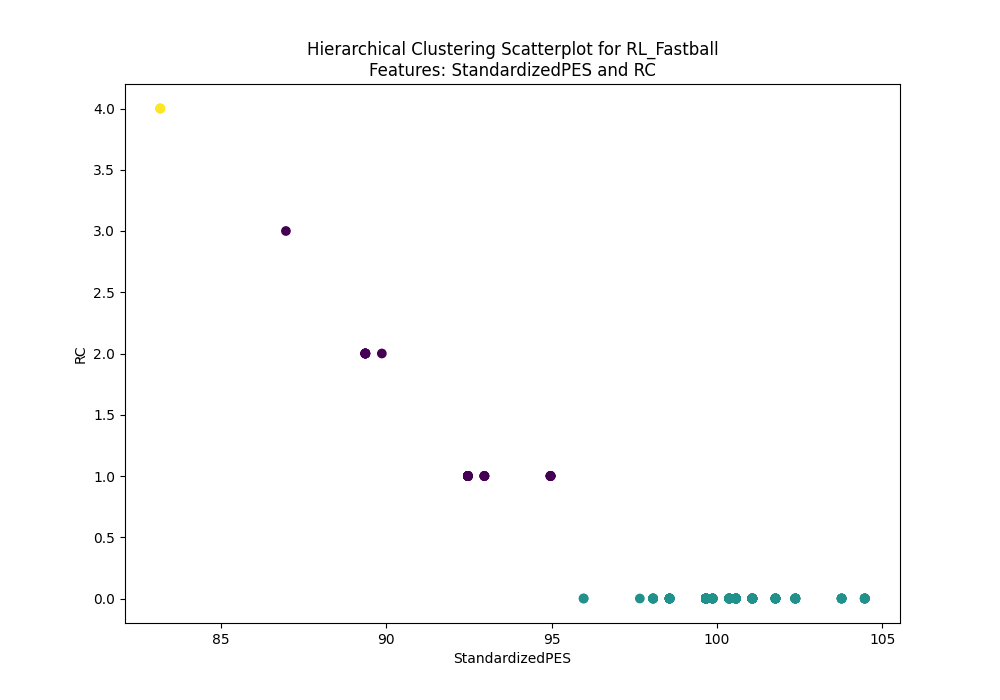

Scatterplot for RL_Fastball


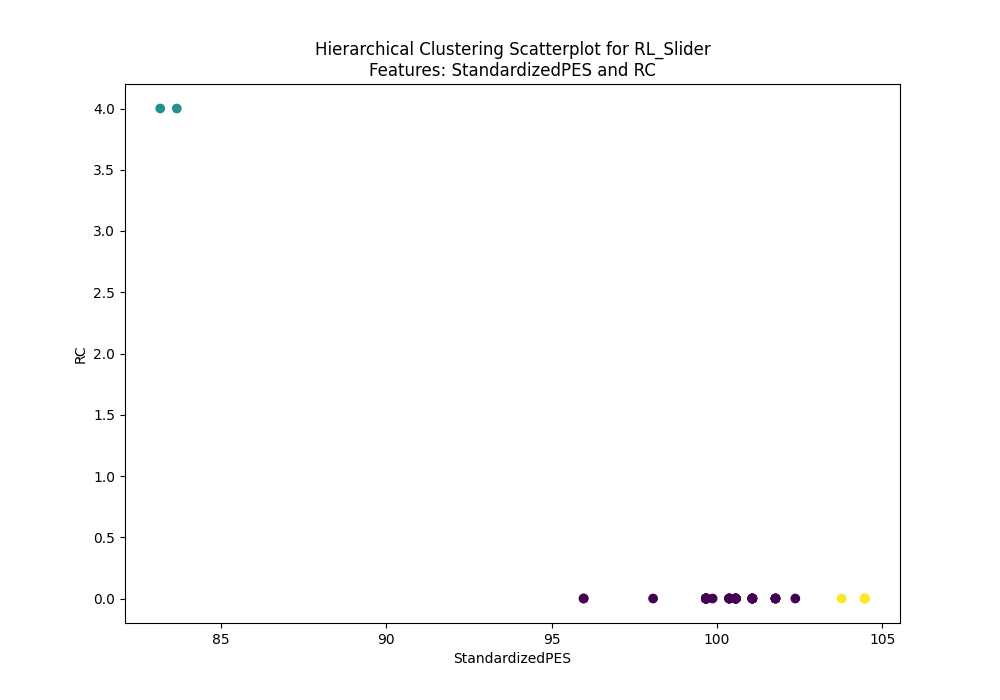

Scatterplot for RL_Slider


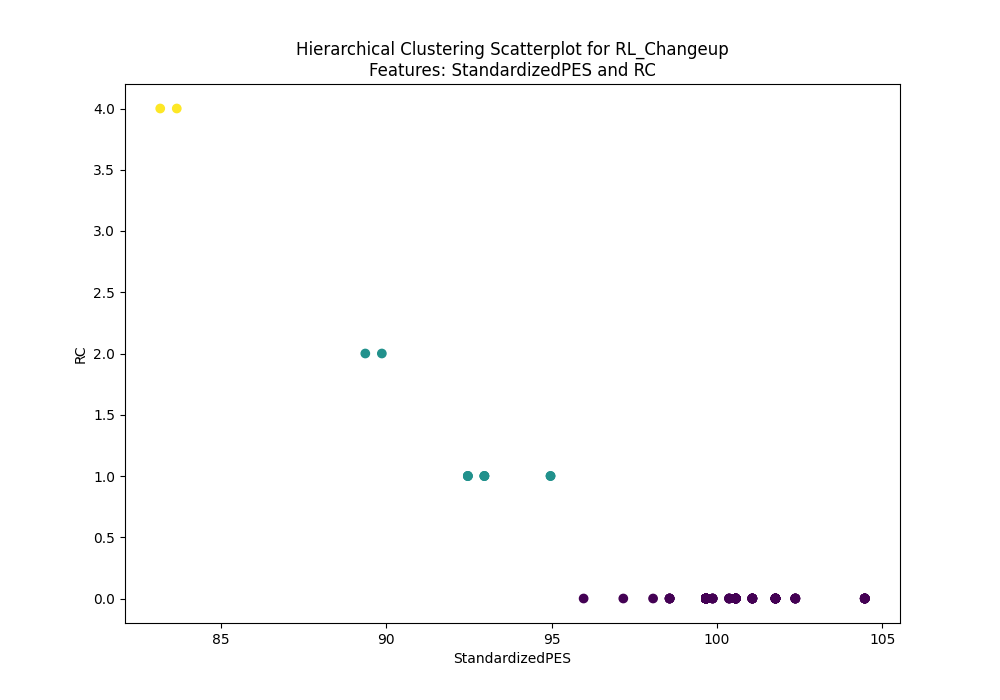

Scatterplot for RL_Changeup


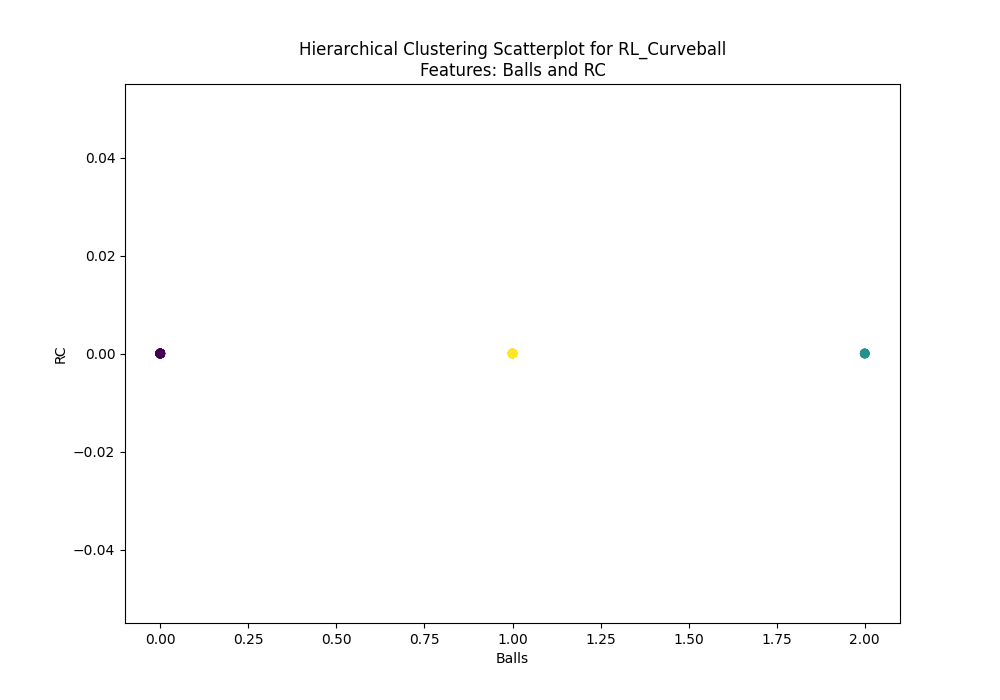

Scatterplot for RL_Curveball


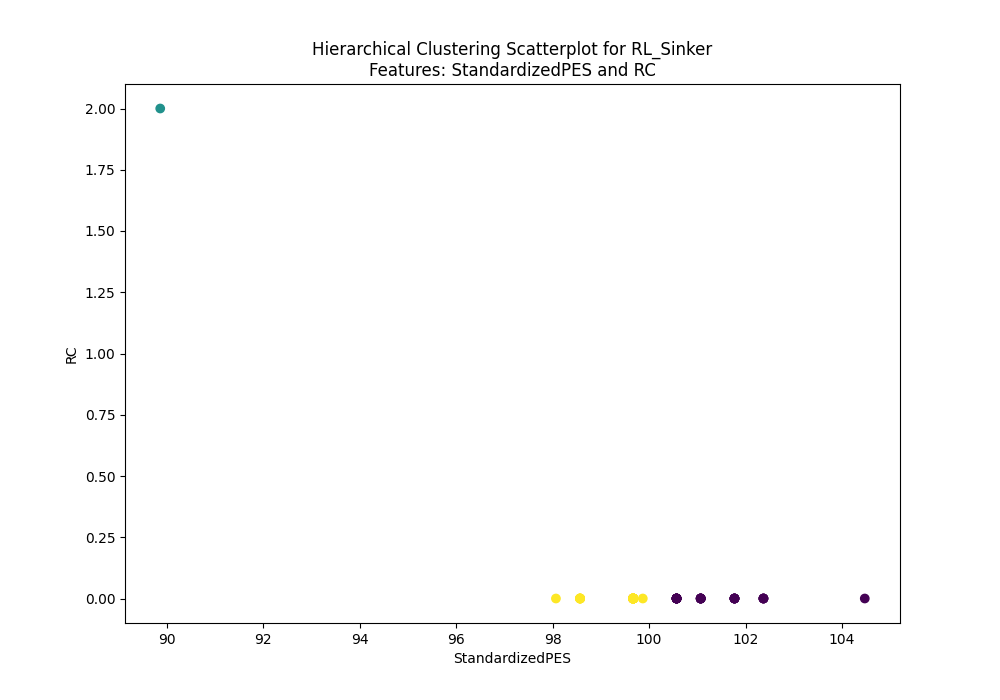

Scatterplot for RL_Sinker


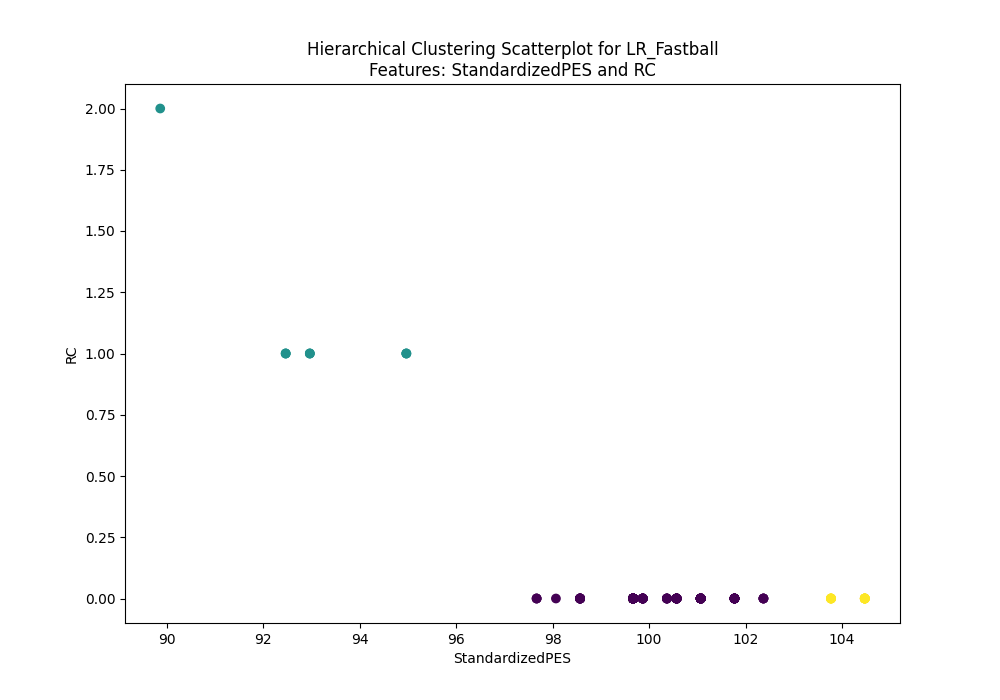

Scatterplot for LR_Fastball


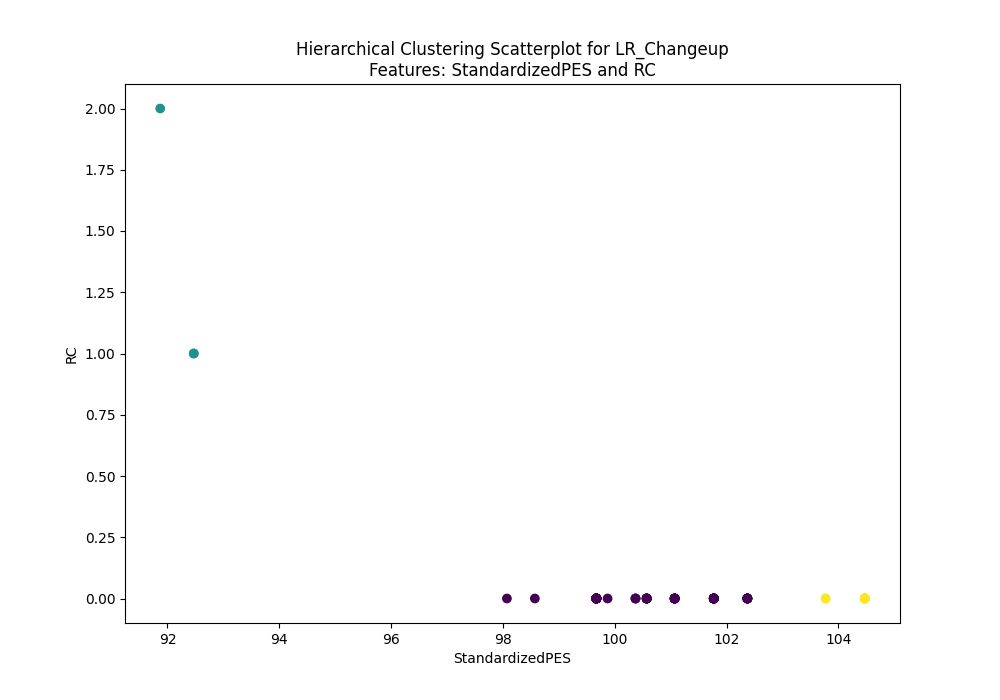

Scatterplot for LR_Changeup


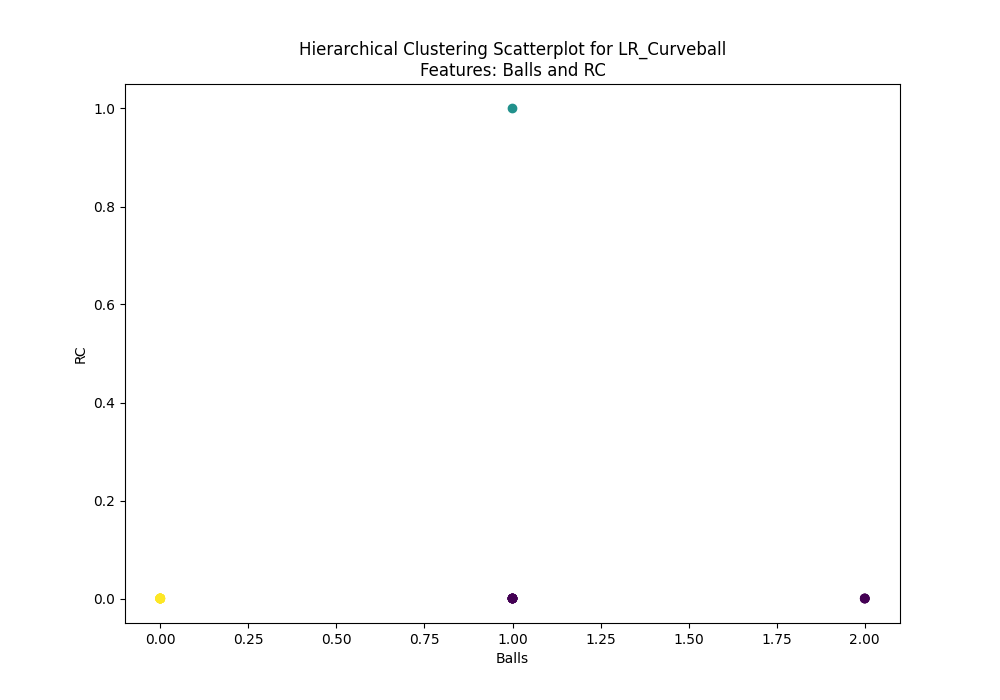

Scatterplot for LR_Curveball


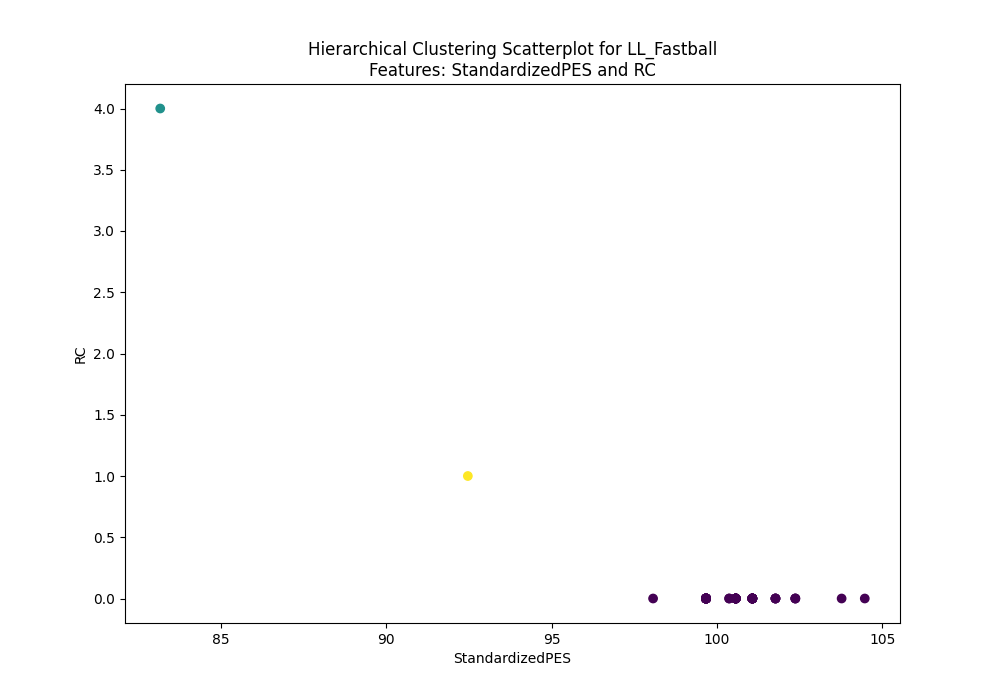

Scatterplot for LL_Fastball


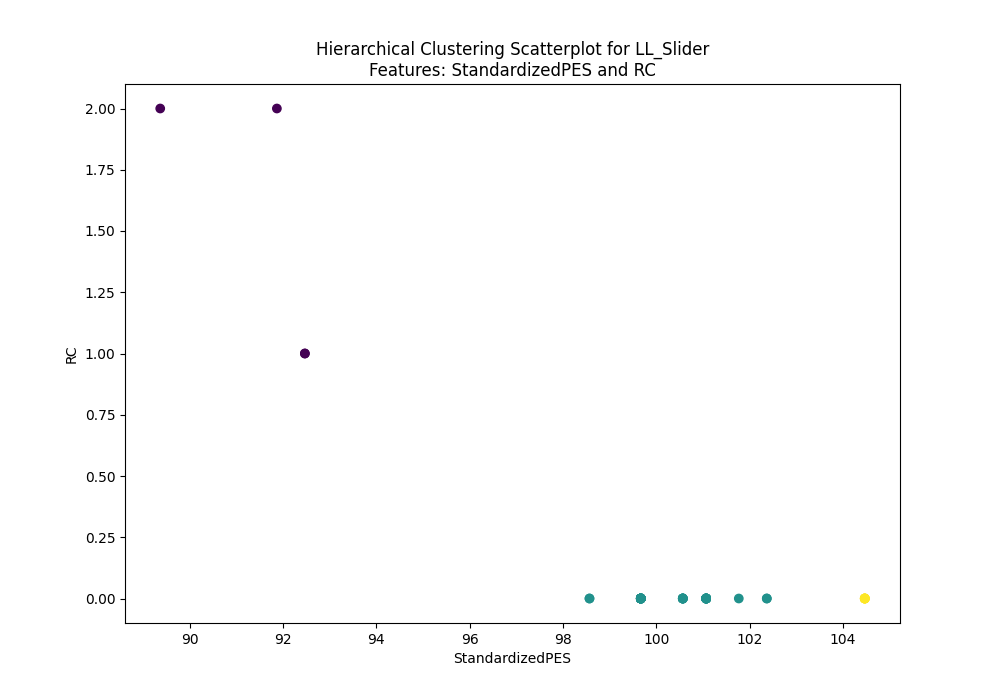

Scatterplot for LL_Slider


In [14]:
from IPython.display import Image, display

for df_name in subset_dfs.keys():
    try:
        display(Image(filename=f'scatterplot_{df_name}.png'))
        print(f"Scatterplot for {df_name}")
    except FileNotFoundError:
        print(f"No Scatterplot found for {df_name}")

### Exit Velocity Random Forest Model

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Iterate through subset DataFrames
for df_name, df in subset_dfs.items():
    # Check if the DataFrame is not empty
    if not df.empty:

        # Prepare data for the model
        X = df.drop('ExitSpeed', axis=1)
        y = df['ExitSpeed']

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create and train the Random Forest model
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)

        # Make predictions on the testing set
        y_pred = model.predict(X_test)

        # Evaluate the model's performance
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
        feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

        print(f"Results for {df_name}:")
        print(f"Mean Squared Error: {mse}")
        print(f"R-squared: {r2}")
        print(f"Important Features: {feature_importance}")
        print("-" * 20)  # Print a separator between results
    else:
        print(f"DataFrame {df_name} is empty. Skipping...")

Results for RR_Fastball:
Mean Squared Error: 416.6054558001445
R-squared: 0.7540947177585184
Important Features:              Feature  Importance
16   StandardizedPES    0.809524
12      PlateLocSide    0.024102
6          RelHeight    0.019151
3       VertRelAngle    0.018470
14     HorzApprAngle    0.018441
9   InducedVertBreak    0.017780
7            RelSide    0.014855
4           SpinRate    0.014165
5           SpinAxis    0.011721
8          Extension    0.010784
10         HorzBreak    0.009752
13     VertApprAngle    0.008570
11    PlateLocHeight    0.008192
2           RelSpeed    0.007025
0              Balls    0.006426
1            Strikes    0.000925
15                RC    0.000117
--------------------
Results for RR_Slider:
Mean Squared Error: 466.6726011697803
R-squared: 0.6146441189211409
Important Features:              Feature  Importance
16   StandardizedPES    0.495883
5           SpinAxis    0.075639
12      PlateLocSide    0.058002
4           SpinRate    0.057

### Pitch Efficiency Score Random Forests Model

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Iterate through subset DataFrames
for df_name, df in subset_dfs.items():
    # Check if the DataFrame is not empty
    if not df.empty:

        # Prepare data for the model
        X = df.drop('StandardizedPES', axis=1)
        y = df['StandardizedPES']

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create and train the Random Forest model
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)

        # Make predictions on the testing set
        y_pred = model.predict(X_test)

        # Evaluate the model's performance
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
        feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

        print(f"Results for {df_name}:")
        print(f"Mean Squared Error: {mse}")
        print(f"R-squared: {r2}")
        print(f"Important Features: {feature_importance}")
        print("-" * 20)  # Print a separator between results
    else:
        print(f"DataFrame {df_name} is empty. Skipping...")

Results for RR_Fastball:
Mean Squared Error: 0.8200390804598007
R-squared: 0.9061851932575287
Important Features:              Feature  Importance
16                RC    0.790508
15         ExitSpeed    0.033473
12      PlateLocSide    0.030494
11    PlateLocHeight    0.022687
1            Strikes    0.021615
14     HorzApprAngle    0.014824
2           RelSpeed    0.012432
7            RelSide    0.011798
4           SpinRate    0.011028
13     VertApprAngle    0.010455
6          RelHeight    0.007285
9   InducedVertBreak    0.007063
10         HorzBreak    0.006630
8          Extension    0.006011
3       VertRelAngle    0.005970
5           SpinAxis    0.005490
0              Balls    0.002238
--------------------
Results for RR_Slider:
Mean Squared Error: 4.193556320754728
R-squared: 0.6919031843846895
Important Features:              Feature  Importance
16                RC    0.438119
11    PlateLocHeight    0.065870
12      PlateLocSide    0.057476
7            RelSide    0.05

### PES Graphs & Analysis

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

# Store Cluster Means for Later
cluster_means_dict = {}

# Function to perform hierarchical clustering and plot scatterplot
def perform_hierarchical_clustering(df, name):
    # Select RelSpeed and ExitSpeed
    data = df[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'HorzBreak', 'PlateLocSide', 'PlateLocHeight', 'SpinAxis', 'ExitSpeed', 'StandardizedPES']]

    # Replace infinite values with NaN
    data = data.replace([np.inf, -np.inf], np.nan)

    # Drop rows with NaN values
    data = data.dropna()

    # Keep only the rows in the original DataFrame that are also in the clustered data
    df = df.loc[data.index]

    # Standardize the features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Perform hierarchical clustering
    n_clusters = 3  # You can adjust the number of clusters
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    clusters = clustering.fit_predict(data_scaled)

    # Add the cluster labels as a new column to the DataFrame
    df['Cluster'] = clusters

    # Plot the scatterplot
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(data['SpinRate'], data['StandardizedPES'], c=clusters, cmap='viridis')
    plt.title(f'Hierarchical Clustering Scatterplot for {name}\nFeatures: RelSpeed and StandardizedPES')
    plt.xlabel('RelSpeed')
    plt.ylabel('StandardizedPES')
    plt.colorbar(scatter, label='Cluster')
    plt.savefig(f'scatterplot_{name}.png')  # Save the plot as PNG
    plt.close()

    # Calculate cluster means for RelSpeed and StandardizedPES
    cluster_means = {}
    for cluster_id in range(n_clusters):
        cluster_means[cluster_id] = {
            'RelSpeed': data['RelSpeed'][clusters == cluster_id].mean(),
            'SpinRate': data['SpinRate'][clusters == cluster_id].mean(),
            'InducedVertBreak': data['InducedVertBreak'][clusters == cluster_id].mean(),
            'HorzBreak': data['HorzBreak'][clusters == cluster_id].mean(),
            'PlateLocSide': data['PlateLocSide'][clusters == cluster_id].mean(),
            'PlateLocHeight': data['PlateLocHeight'][clusters == cluster_id].mean(),
            'SpinAxis': data['SpinAxis'][clusters == cluster_id].mean(),
            'ExitSpeed': data['ExitSpeed'][clusters == cluster_id].mean(),
            'StandardizedPES': data['StandardizedPES'][clusters == cluster_id].mean()
        }

    # Return clustered data and cluster means # This line has been added to return the required values
    return data, cluster_means

# Iterate through subset DataFrames
for df_name, df in subset_dfs.items():
    required_columns = ['RelSpeed', 'SpinRate', 'InducedVertBreak', 'HorzBreak', 'PlateLocSide', 'PlateLocHeight', 'SpinAxis', 'ExitSpeed', 'StandardizedPES']

    # Check if the DataFrame is not empty, has at least 2 samples, and contains 'RelSpeed' and 'StandardizedPES' columns
    if not df.empty and len(df) >= 2 and 'RelSpeed' in df.columns and 'StandardizedPES' in df.columns:
        print(f"Processing {df_name}...")

        # Perform hierarchical clustering
        clustered_data, cluster_means = perform_hierarchical_clustering(df, df_name)

        # Store cluster means
        cluster_means_dict[df_name] = cluster_means
    else:
        print("Wrong Dataframe")

Processing RR_Fastball...
Processing RR_Slider...
Processing RR_Splitter...
Processing RR_Changeup...
Processing RR_Curveball...
Processing RR_Cutter...
Processing RR_Sinker...
Processing RL_Fastball...
Processing RL_Slider...
Processing RL_Changeup...
Processing RL_Curveball...
Processing RL_Sinker...
Processing LR_Fastball...
Processing LR_Changeup...
Processing LR_Curveball...
Processing LL_Fastball...
Processing LL_Slider...


#### Create a Table to display all of the Cluster Means (To **Right-Handed** Hitter)

Horizontal Thirds (**PlateLocSide**):

*   Inside third: -0.708 to -0.236
*   Middle third: -0.236 to 0.236
*   Outside third: 0.236 to 0.708  

Vertical Thirds (**PlateLocHeight**):
*   Lower third: 1.5 to 2.17
*   Middle third: 2.17 to 2.83
*   Upper third: 2.83 to 3.5

In [18]:
import pandas as pd

# Create a list to store all data
all_data = []

# Iterate through each pitch type and its cluster means
for pitch_type, means in cluster_means_dict.items():
    for cluster_id, row in means.items():
        all_data.append({
            'Pitch Type': pitch_type,
            'Cluster': cluster_id,
            'RelSpeed': row['RelSpeed'],
            'SpinRate': row['SpinRate'],
            'InducedVertBreak': row['InducedVertBreak'],
            'HorzBreak': row['HorzBreak'],
            'PlateLocSide': row['PlateLocSide'],
            'PlateLocHeight': row['PlateLocHeight'],
            'SpinAxis': row['SpinAxis'],
            'ExitSpeed': row['ExitSpeed'],
            'StandardizedPES': row['StandardizedPES']
        })

# Create a DataFrame from all_data
df_all_means = pd.DataFrame(all_data)

# Set 'Pitch Type' and 'Cluster' as multi-index
df_all_means.set_index(['Pitch Type', 'Cluster'], inplace=True)

# Sort the index
df_all_means.sort_index(inplace=True)
df_all_means = df_all_means.round(2)

df_all_means

RelSpeed  SpinRate  InducedVertBreak  HorzBreak  \
Pitch Type   Cluster                                                    
LL_Fastball  0           89.50   2222.80             18.18     -10.95   
             1           84.04   1978.39             10.49     -14.74   
             2           89.72   2197.30             18.13      -7.54   
LL_Slider    0           81.00   2270.36             -0.16       4.51   
             1           79.44   2083.23              0.38       3.42   
             2           77.64   2177.54              2.85       6.41   
LR_Changeup  0           81.89   1781.32             10.52     -14.82   
             1           81.12   1883.95              6.16     -16.78   
             2           78.36   2022.54              0.62       5.47   
LR_Curveball 0           77.26   2194.97             -5.68       4.91   
             1           90.11   2233.31             19.83      -3.54   
             2           75.43   2311.70             -4.76      10.00   
LR_Fastball  0           89.20   2236.47             18.24     -11.06   
             1           85.89   1982.73              8.70     -16.03   
             2           89.06   2240.74             17.83     -12.72   
RL_Changeup  0           82.17   1738.51              9.22      15.95   
             1           77.19   1930.30              1.13      -8.76   
             2           82.46   1747.37              7.43      15.49   
RL_Curveball 0           75.25   2260.17             -5.81     -11.36   
             1           78.99   1672.92             12.62      16.12   
             2           76.60   2749.99            -12.09     -15.30   
RL_Fastball  0           89.55   2211.69             18.61       9.76   
             1           87.20   2098.42              9.51      17.66   
             2           88.05   2160.19             15.80      11.44   
RL_Sinker    0           92.05   2385.32              9.35      17.66   
             1           86.56   2150.20             -2.00      18.22   
             2           92.72   2375.05              7.88      17.92   
RL_Slider    0           78.46   2277.19              3.31      -6.24   
             1           82.71   2647.44             -4.84      -9.72   
             2           83.50   2663.68              0.68      -9.64   
RR_Changeup  0           81.51   1626.29              5.89      15.94   
             1           77.45   1963.16              1.01      -4.69   
             2           80.35   1764.86             12.59      14.78   
RR_Curveball 0           78.57   2114.53             -3.27      -5.22   
             1           75.42   2561.04            -11.53     -15.29   
             2           77.22   2369.67             -6.96     -11.00   
RR_Cutter    0           84.64   2450.05             10.17       1.10   
             1           85.61   2462.71             12.79      -1.48   
             2           84.85   2394.04              9.59      -1.07   
RR_Fastball  0           89.95   2215.50             18.50       8.71   
             1           86.88   2066.42             10.63      15.68   
             2           88.60   2161.33             14.19      14.06   
RR_Sinker    0           92.98   2393.20             10.07      18.00   
             1           84.67   2187.81              0.23      17.81   
             2           91.70   2343.64              6.06      19.17   
RR_Slider    0           79.91   2363.58              0.84      -8.51   
             1           83.02   2321.80              7.66      -2.18   
             2           80.56   2520.14              0.06      -7.81   
RR_Splitter  0           81.11   1073.33              4.96      13.12   
             1           83.09   1838.48              2.90     -12.10   
             2           84.09   1208.33              9.70      13.16   

                      PlateLocSide  PlateLocHeight  SpinAxis  ExitSpeed  \
Pitch Type   Cluster                                                      
LL

#### Notes On Specific Matchups

| Matchup \ Pitch | Four-Seam Fastball |
|----------|:----------|
| RR | Clusters: 0 / Keys: Inner Third Location (Black/Ball In)|
| RL | Clusters: 1, 2 / Keys: Elite Vert (17-19), *Up/Out OR Low/In*  |
| LR | Clusters: 0 / Keys: Elite Vert (18+), *Up/In*|
| LL | Clusters: 1, 3 / Keys: 1 w/ Elite vert (19+), UP/Out Location ! 3 w/ Low vert (16), Some Run (-13), DOWN/Out |

 ------------------

| Matchup \ Pitch | Slider |
|----------|:----------|
| RR | Clusters: 1, 2 / Keys: 1 w/ Slower + Sweepy (78mph, 0-1V/9H) !  2 w/ Faster + Gyro (83mph, 6V/-3H)|
| RL | Clusters: 0, 2/ Keys: 0 w/ Gyro (4V/-4H) ! 2 w/ *(-1V)* Sweep (-9H) LOW |
| LR | N/A |
| LL | Clusters: 1, 2 / Keys: 1 w/ Huge Sweep (18H), INSIDE ! 2 w/ Gyro (3V/5H), LOW|

 ------------------

| Matchup \ Pitch | Changeup |
|----------|:----------|
| RR | Clusters: 1 / Keys: Unimpressive movement profile (12V/14H), Low/Outside |
| RL | Clusters: 0, 1 / Keys: Only difference btwn 1/2 is location: **Miss DOWN** ! 0? |
| LR | Clusters: 0, 2, 3 / Keys: Extremely Successful Pitch ! Only hot zone i middle/middle|
| LL | N/A|

 ------------------

| Matchup \ Pitch | Curveball |
|----------|:----------|
| RR | Clusters: 2, 3 / Keys: Super Successful Pitch Matchup, keep to black/ball down|
| RL | Clusters: 1, 2 / Keys: Also Successful Pitch Matchup, Needs vert (-15)|
| LR | Clusters: / Keys:|
| LL | N/A|

 ------------------

Scatterplot for RR_Fastball


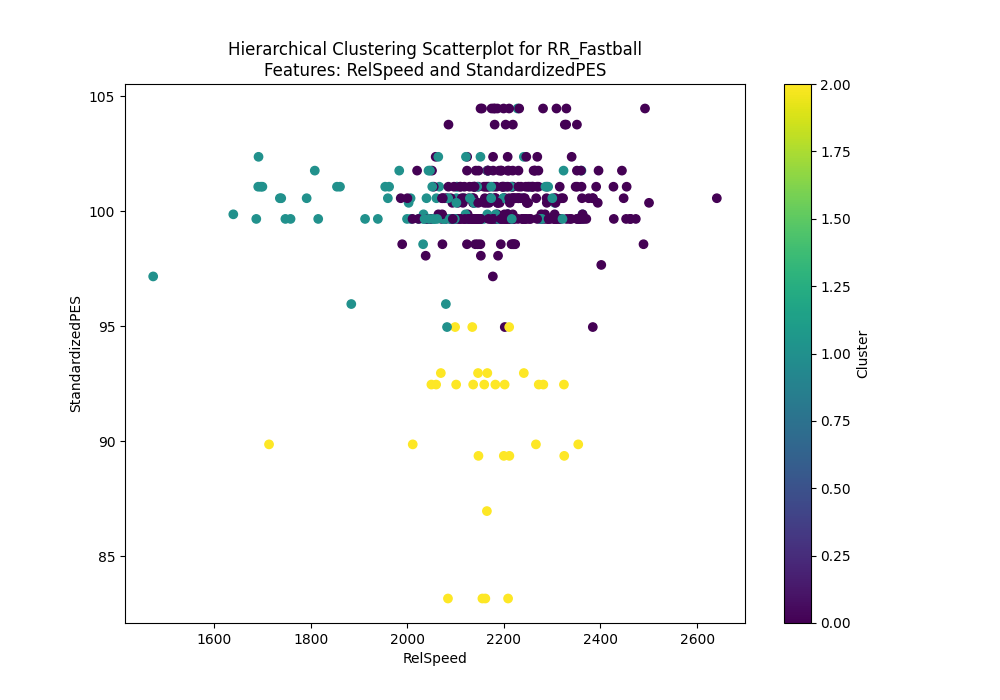

Scatterplot for RR_Slider


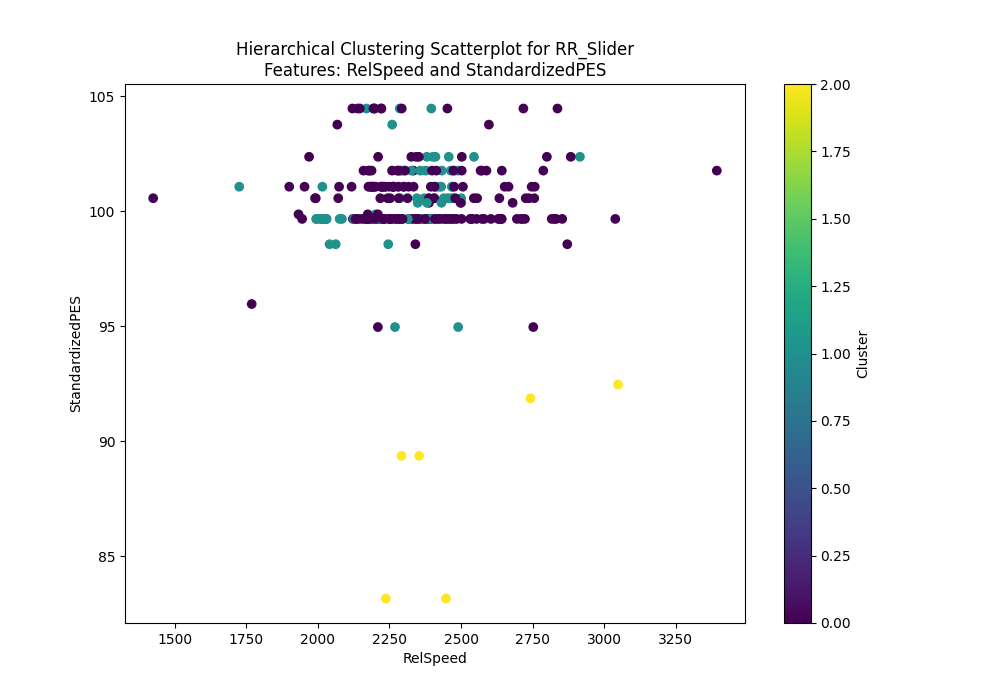

Scatterplot for RR_Splitter


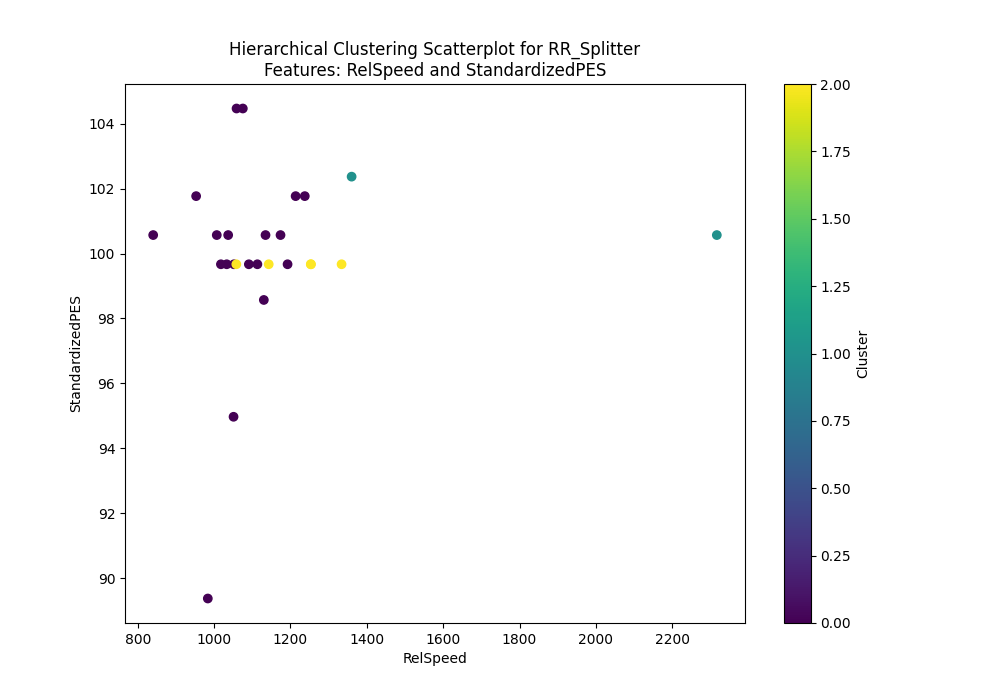

Scatterplot for RR_Changeup


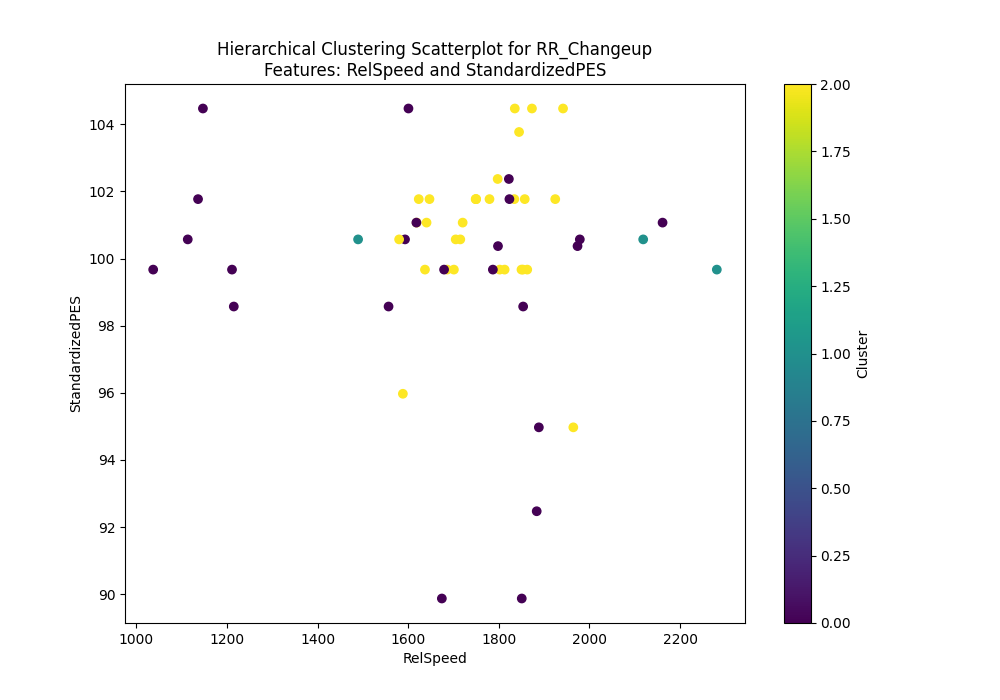

Scatterplot for RR_Curveball


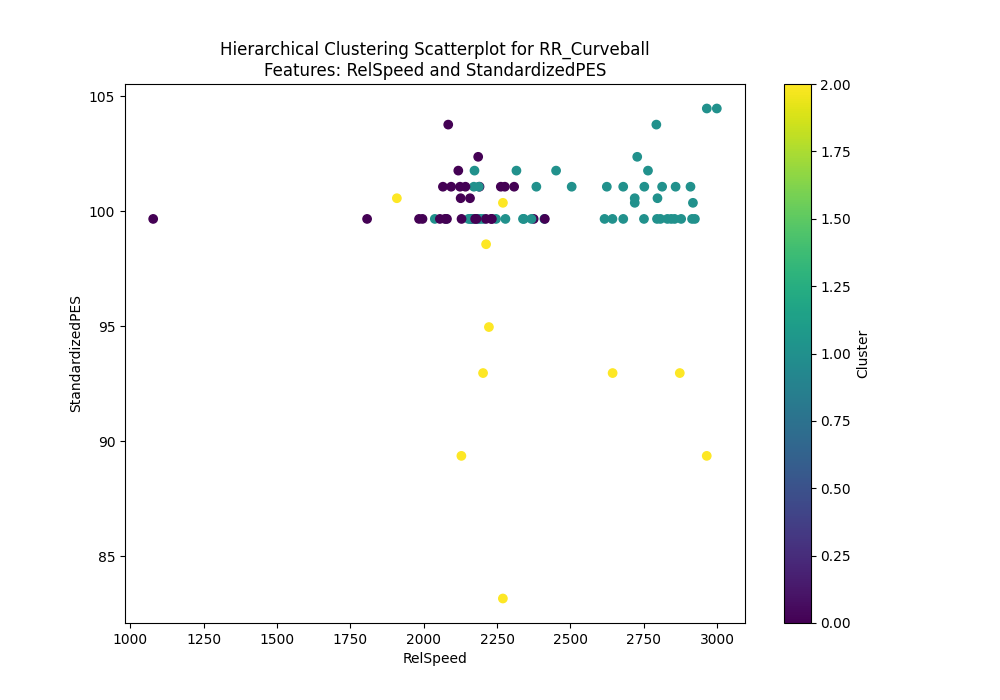

Scatterplot for RR_Cutter


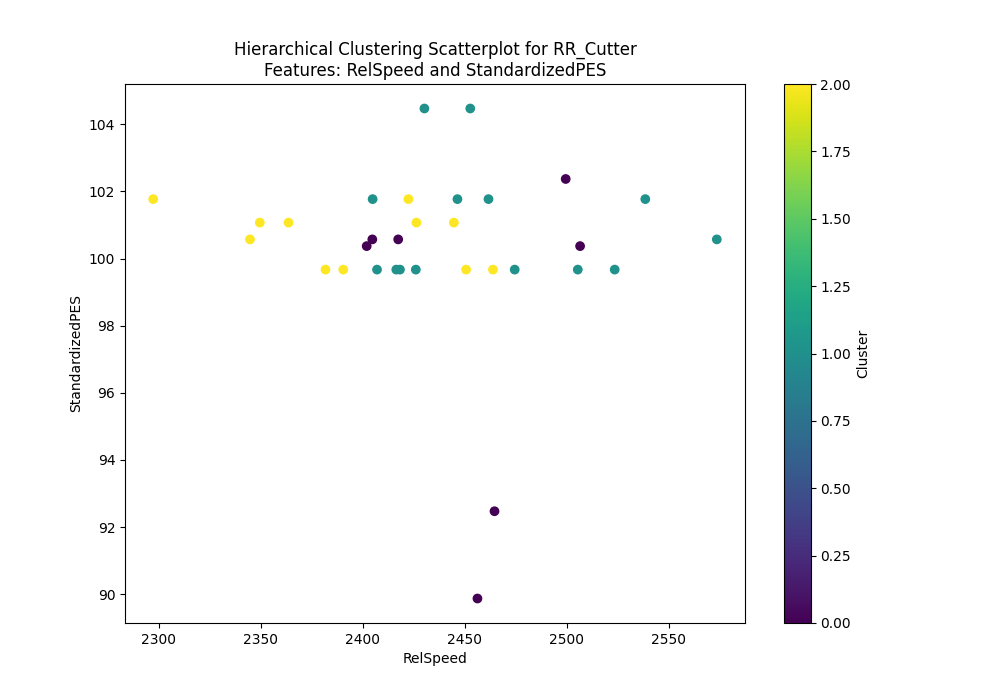

Scatterplot for RR_Sinker


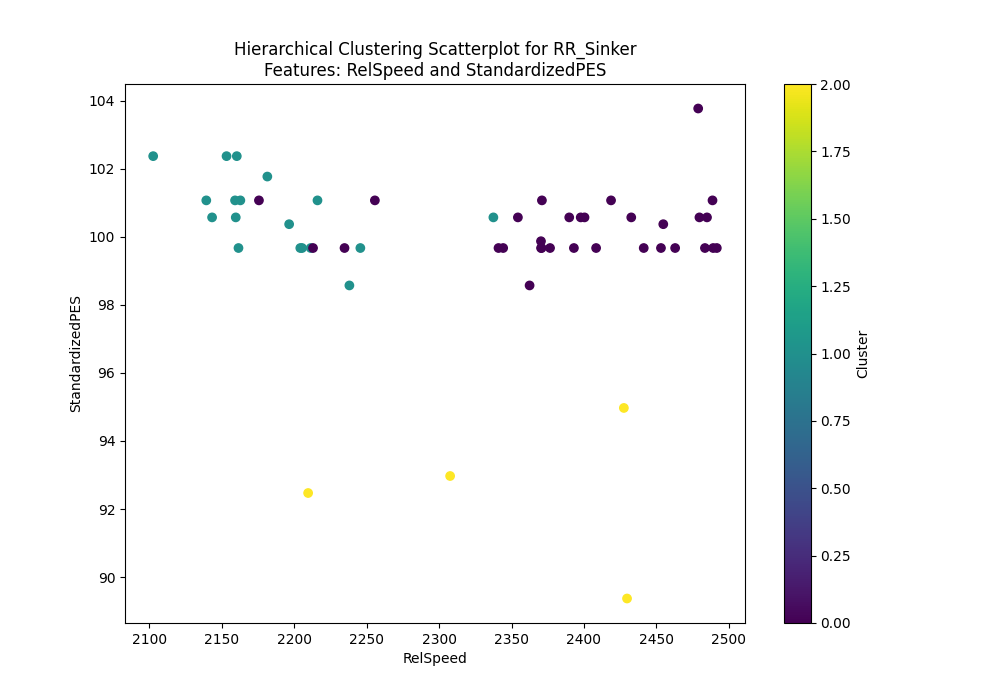

Scatterplot for RL_Fastball


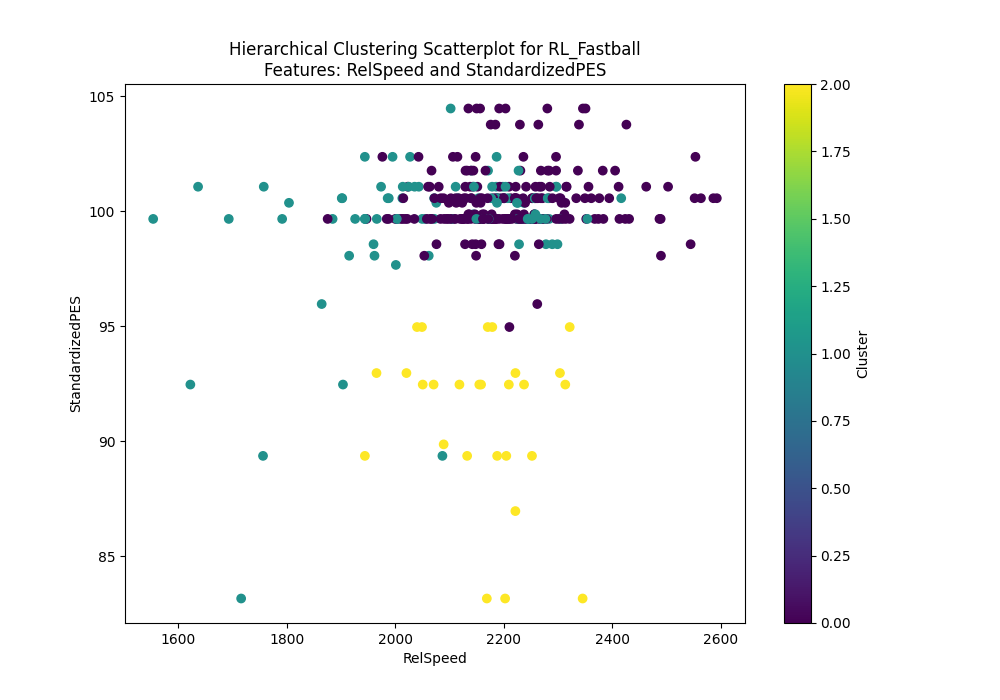

Scatterplot for RL_Slider


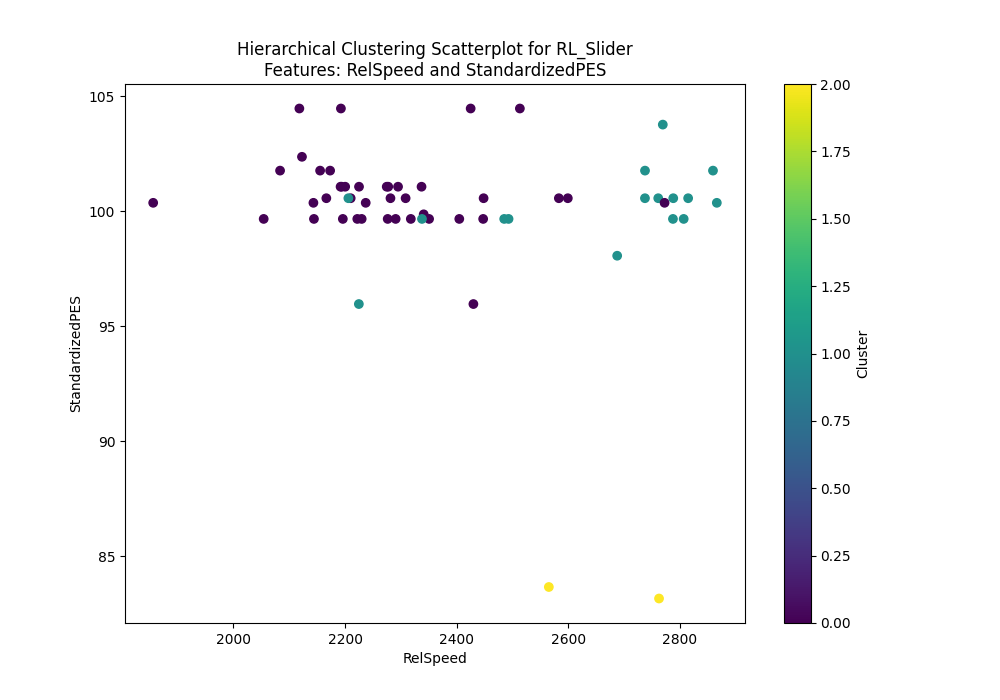

Scatterplot for RL_Changeup


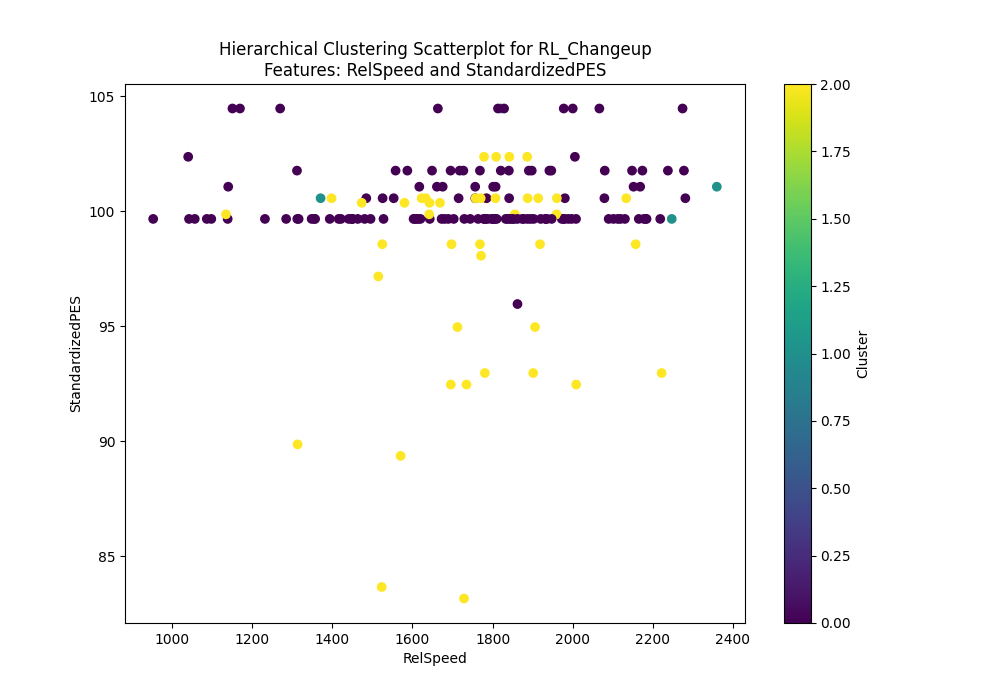

Scatterplot for RL_Curveball


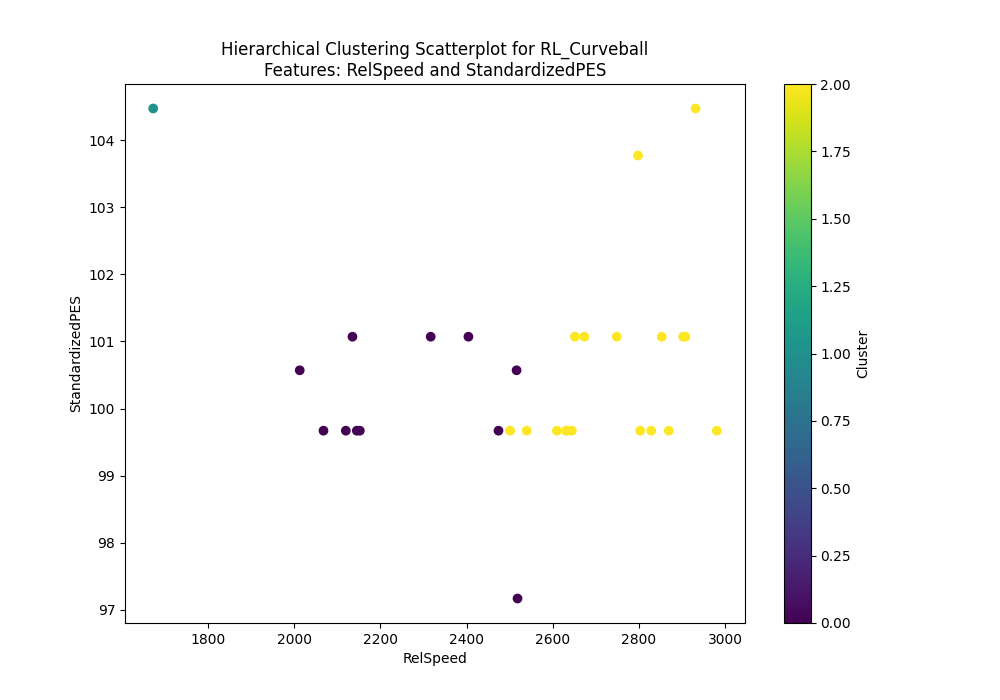

Scatterplot for RL_Sinker


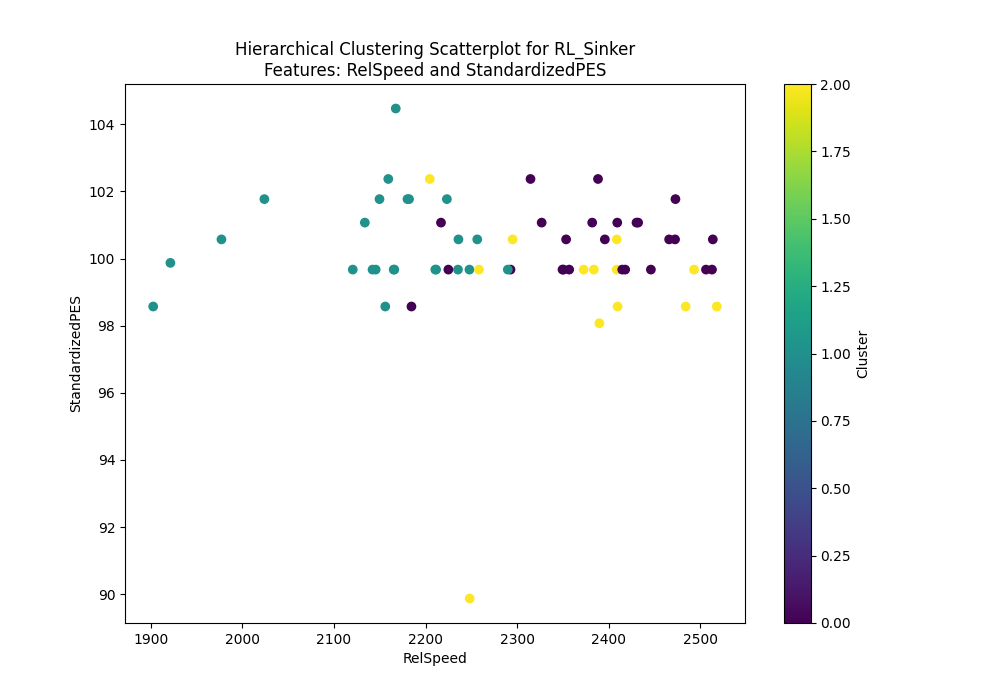

Scatterplot for LR_Fastball


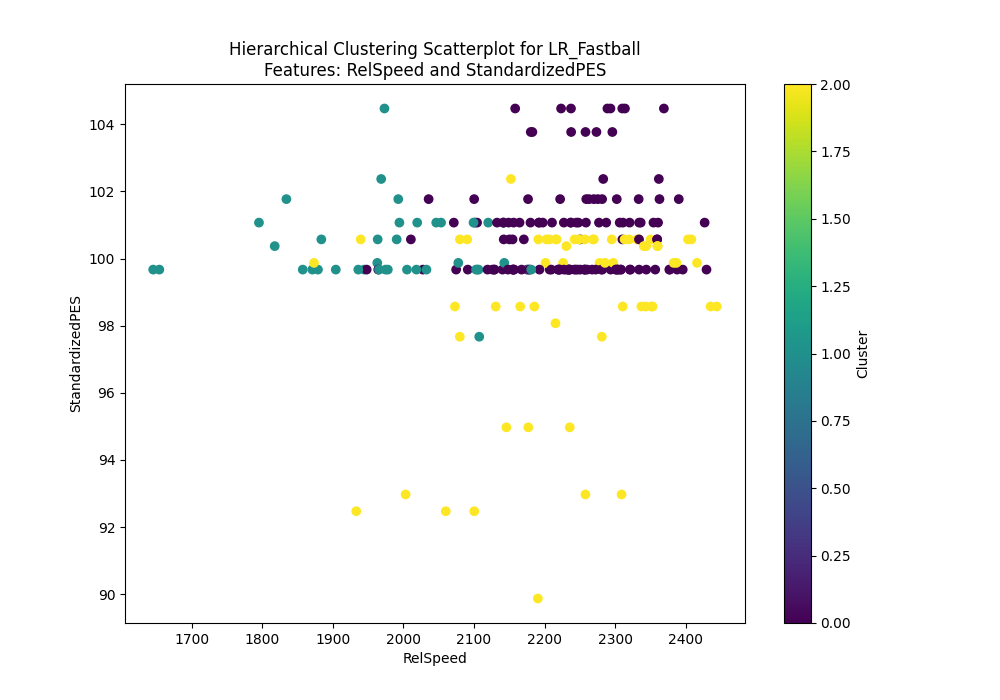

Scatterplot for LR_Changeup


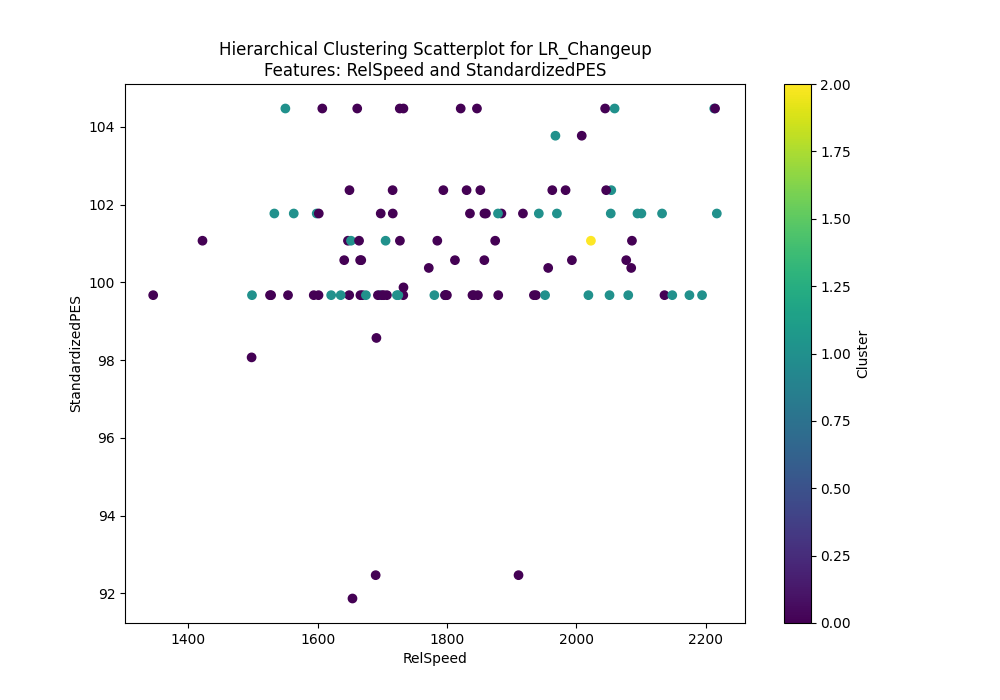

Scatterplot for LR_Curveball


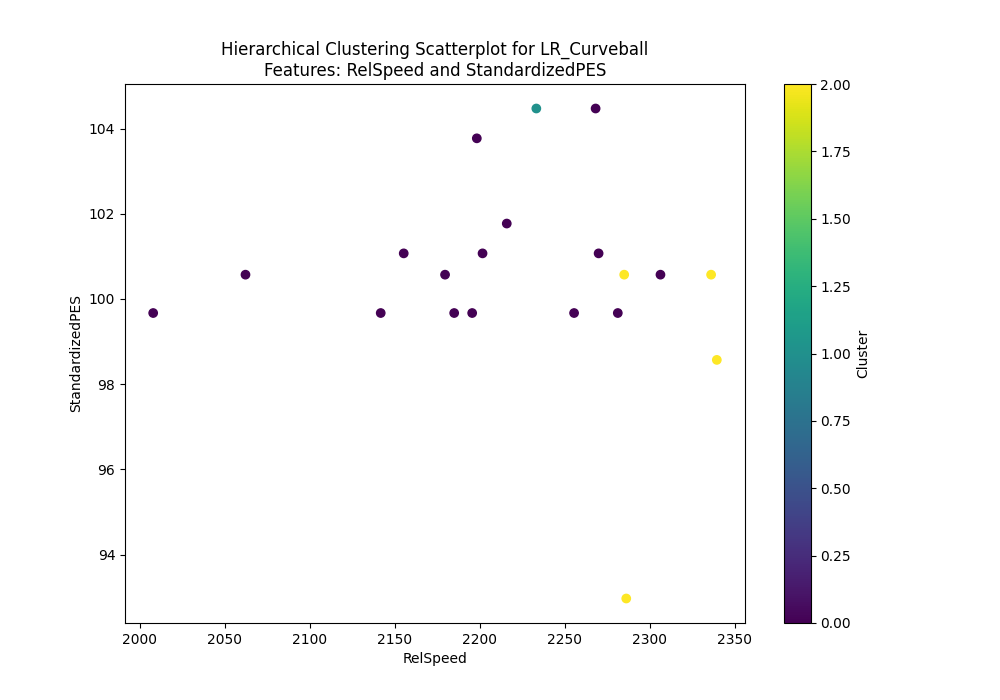

Scatterplot for LL_Fastball


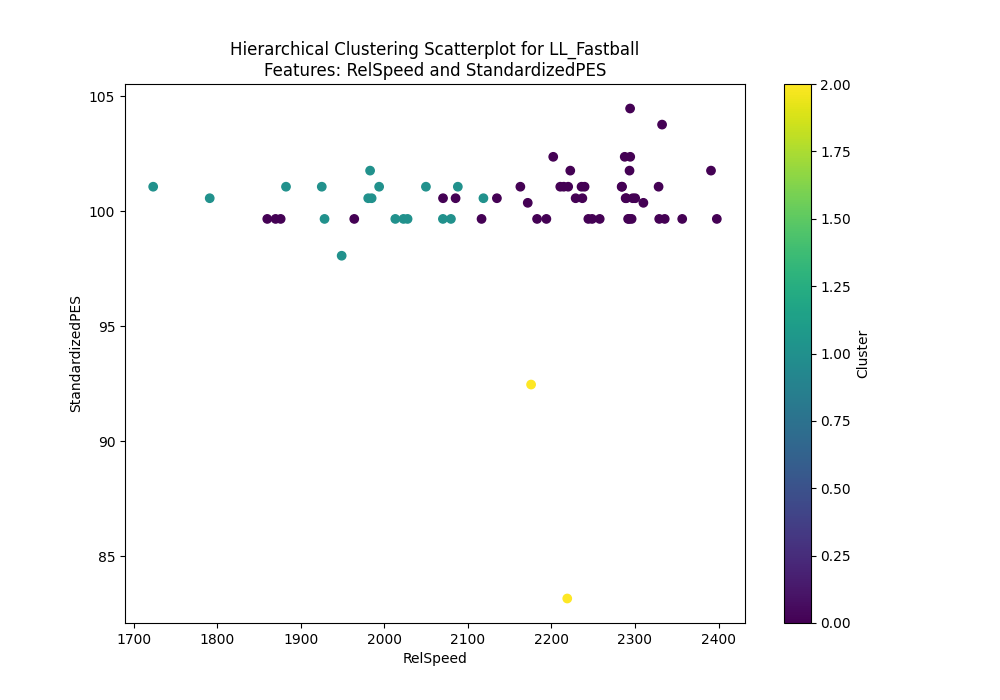

Scatterplot for LL_Slider


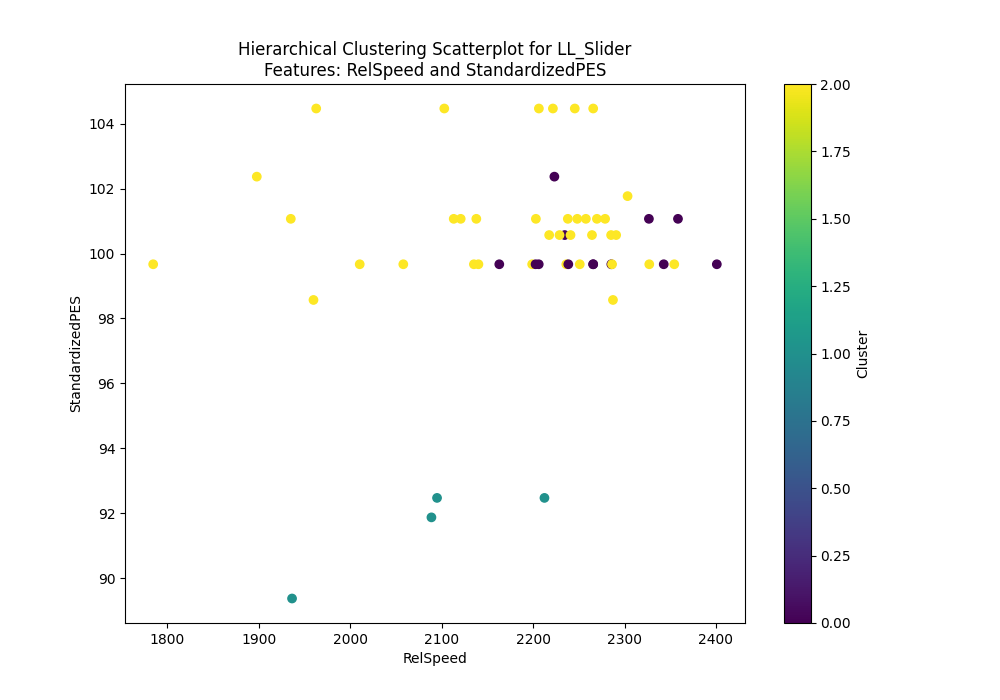

In [19]:
from IPython.display import Image, display

for df_name in subset_dfs.keys():
    try:
        print(f"Scatterplot for {df_name}")
        display(Image(filename=f'scatterplot_{df_name}.png'))
    except FileNotFoundError:
        print(f"No Scatterplot found for {df_name}")

# Decision Tree Model

Processing RR_Fastball...


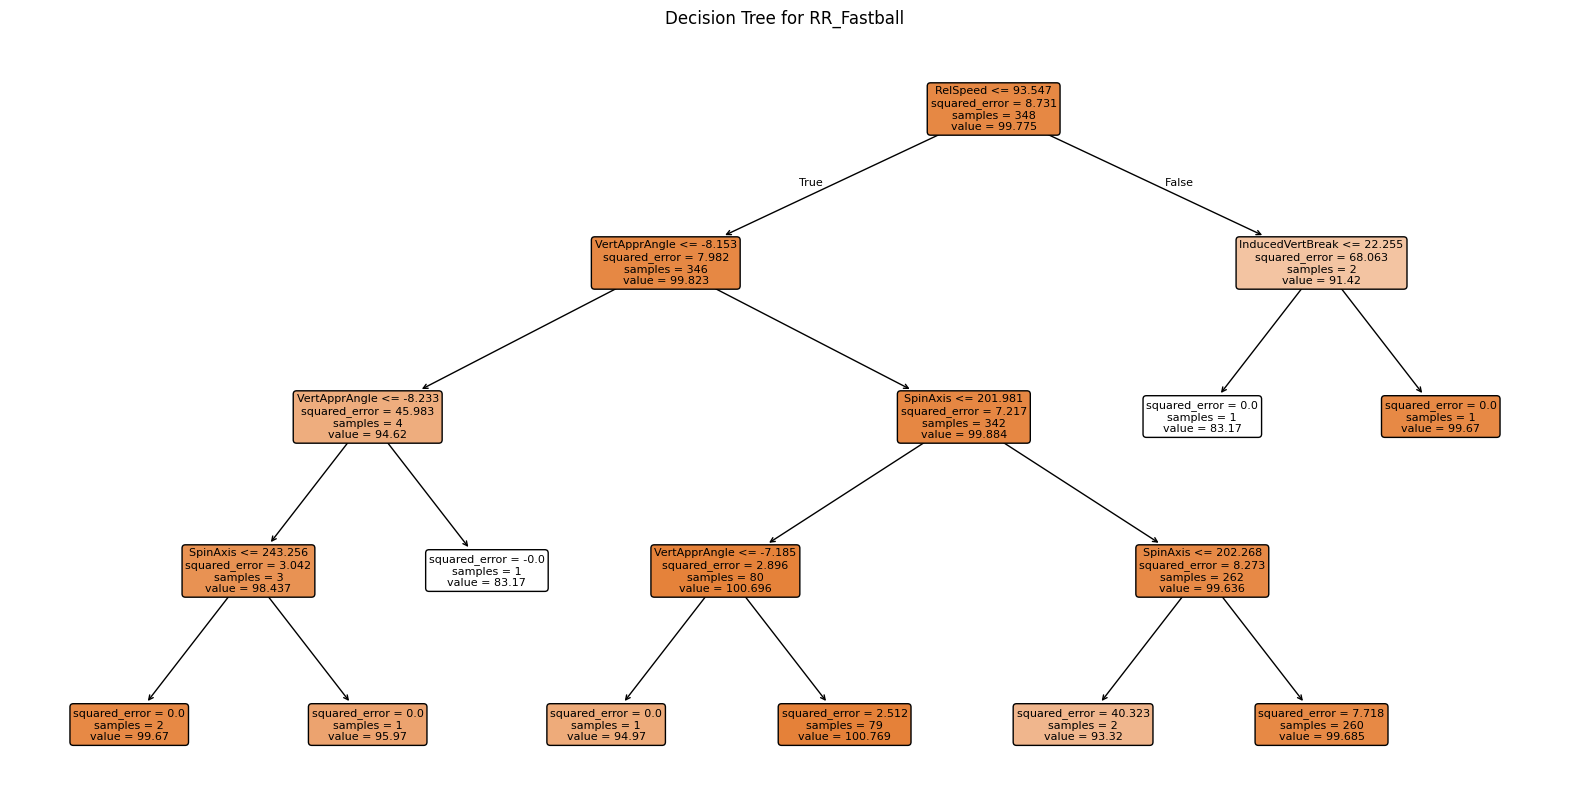

Processing RR_Slider...


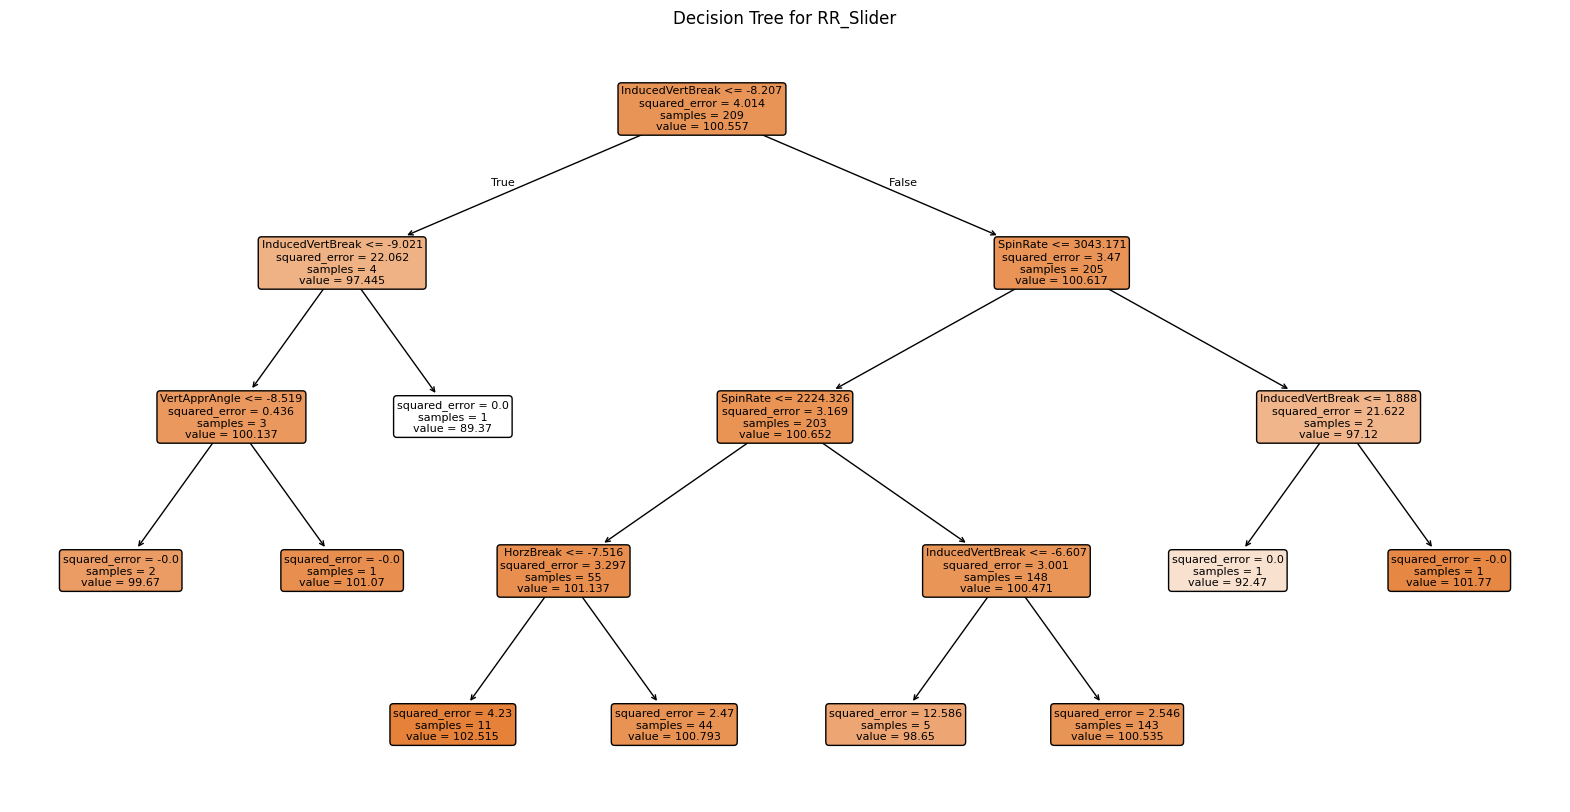

Processing RR_Splitter...


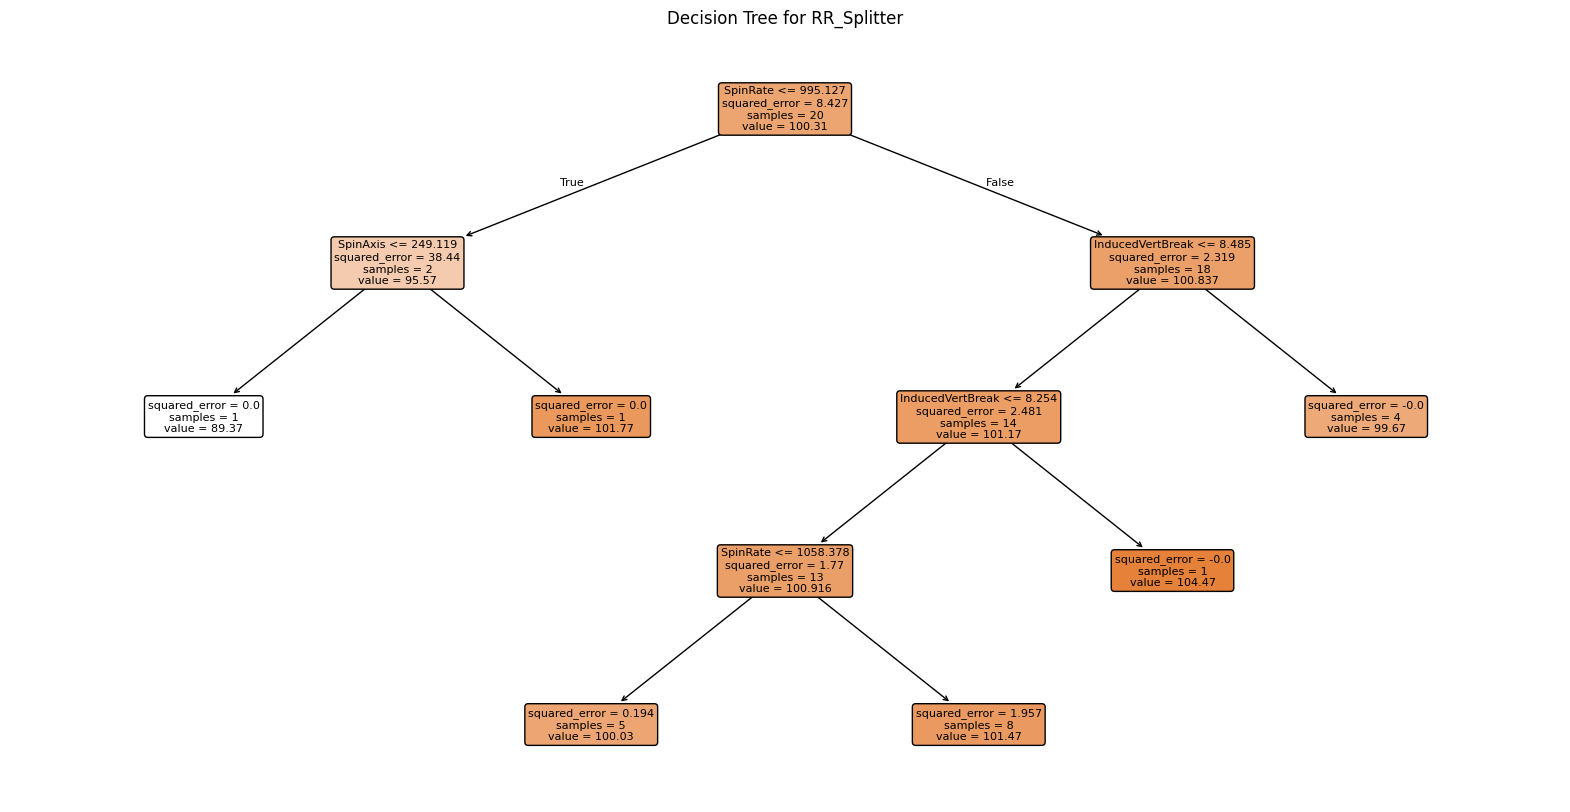

Processing RR_Changeup...


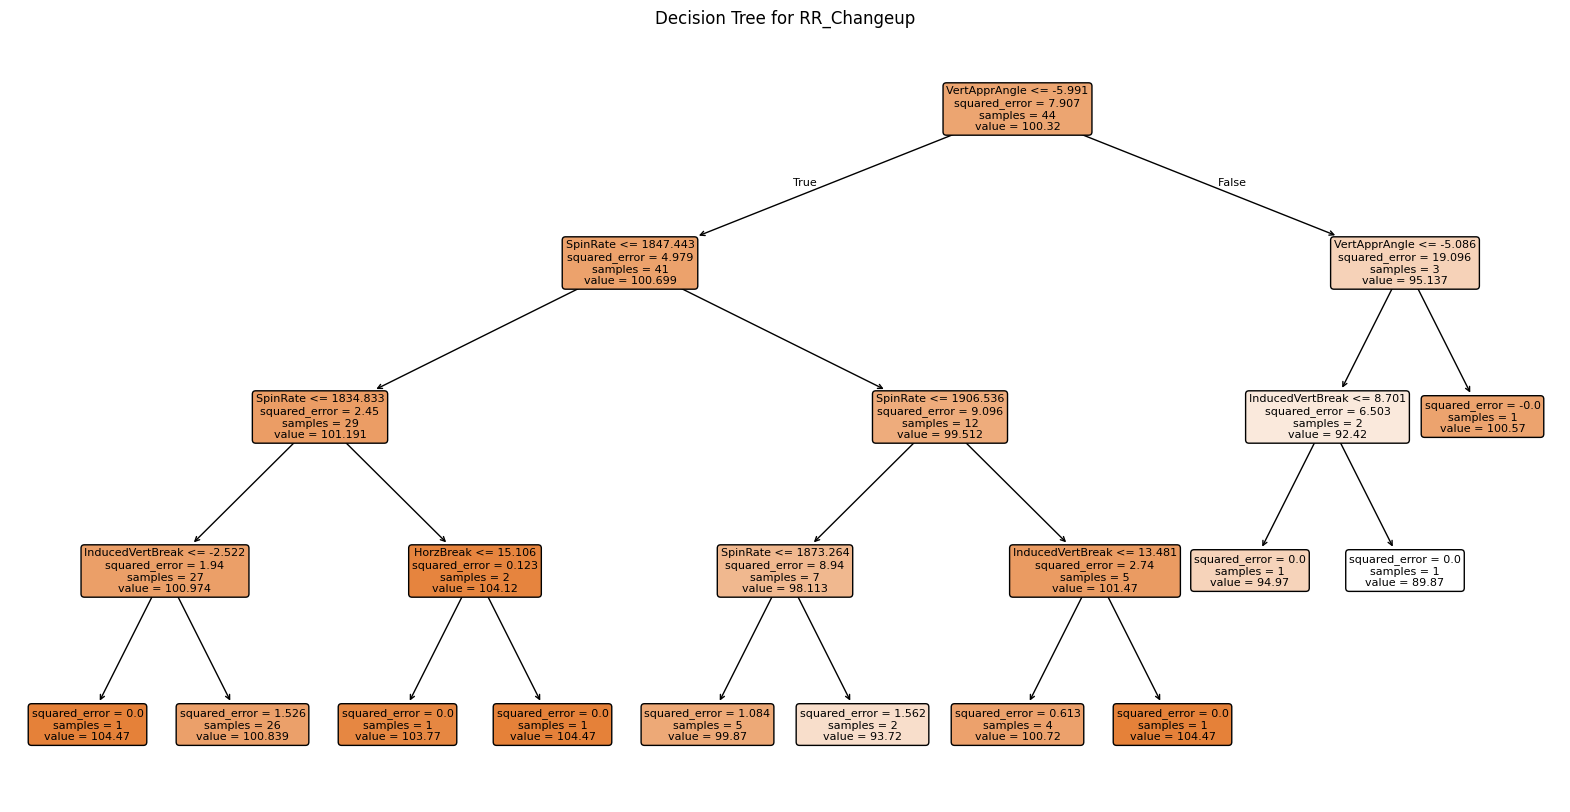

Processing RR_Curveball...


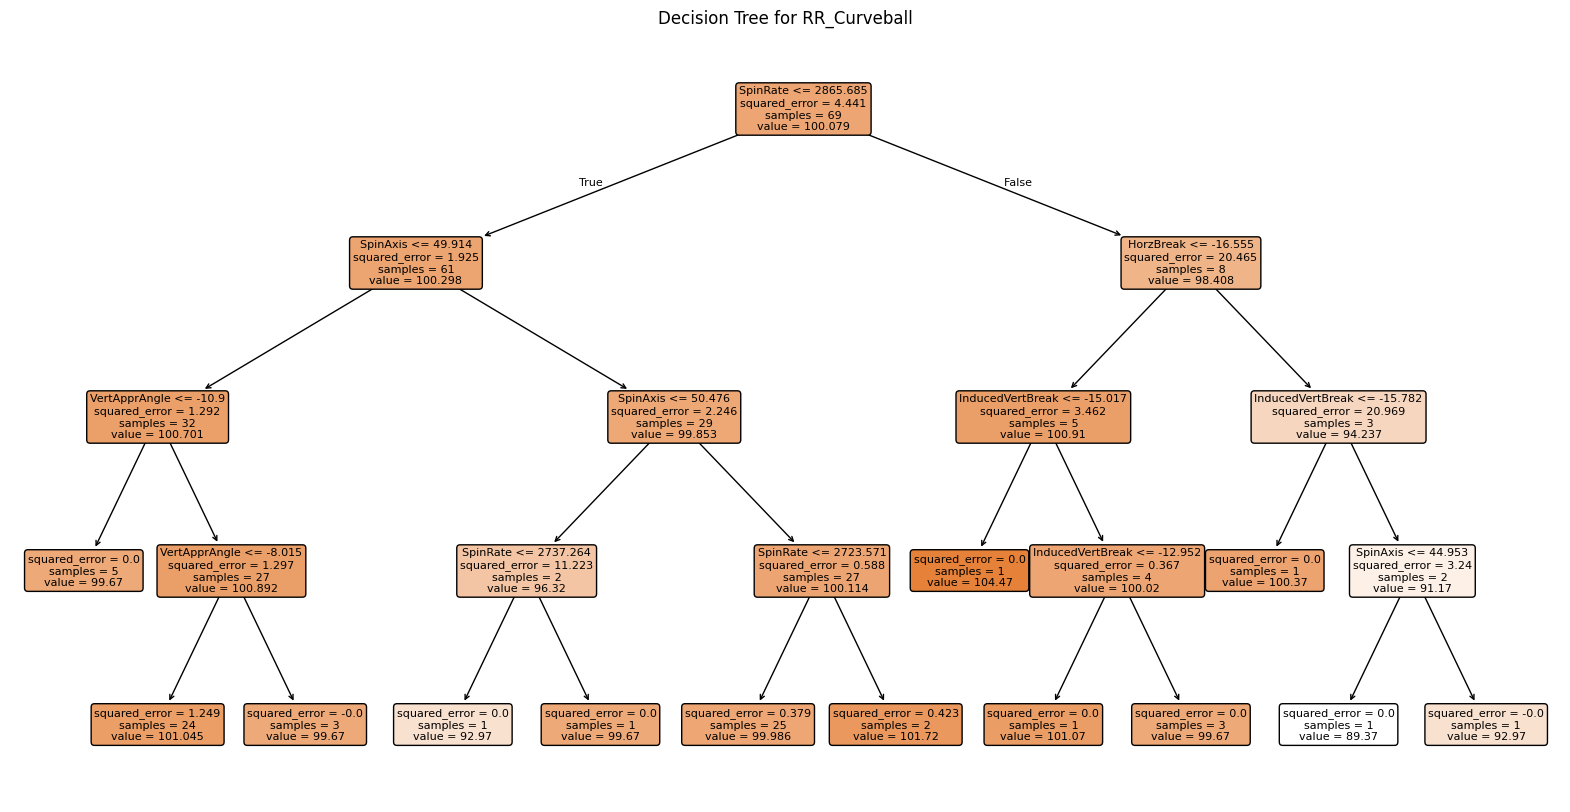

Processing RR_Cutter...


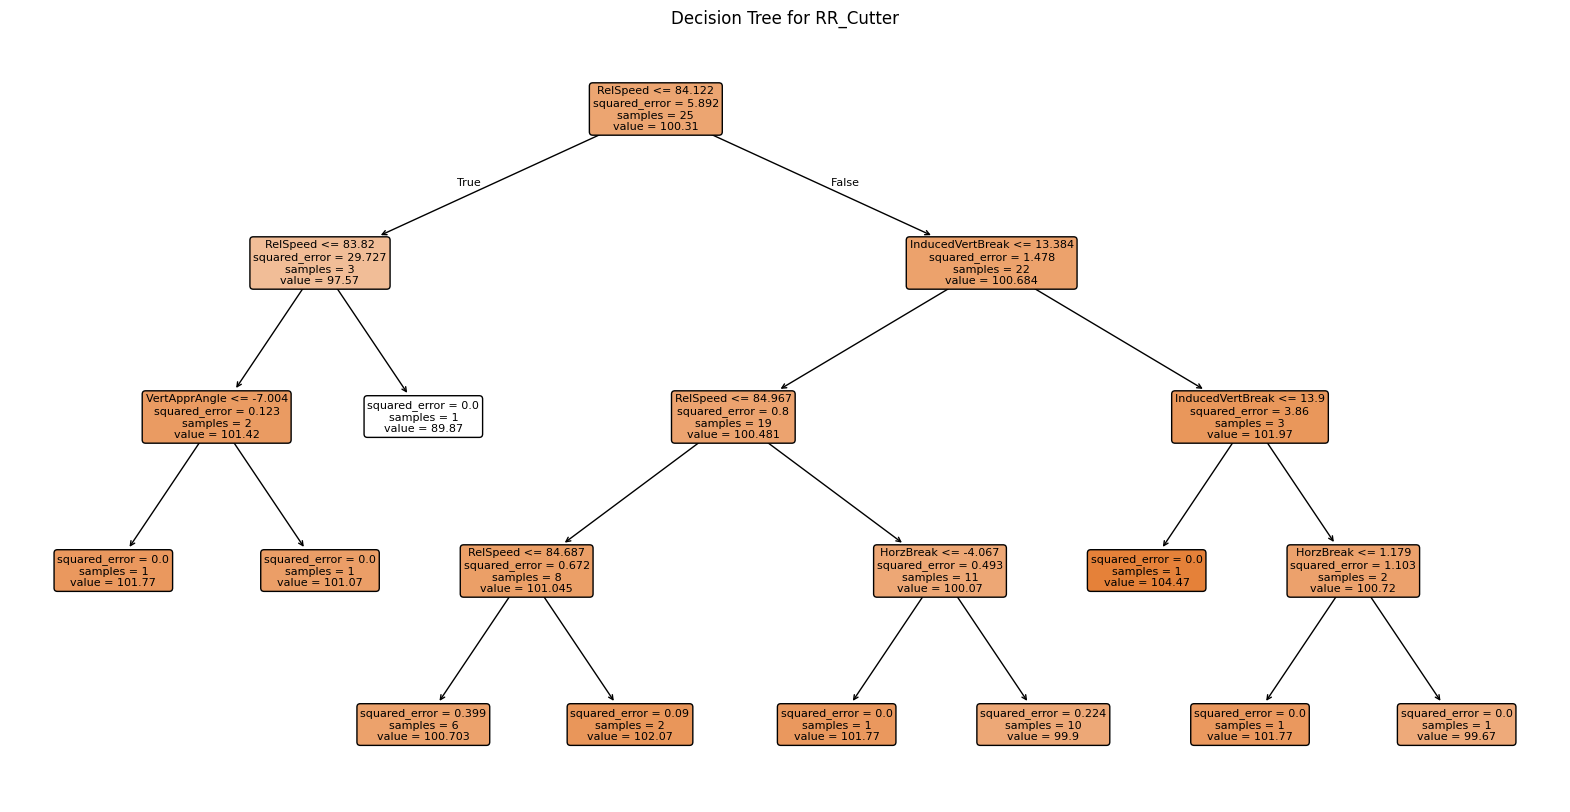

Processing RR_Sinker...


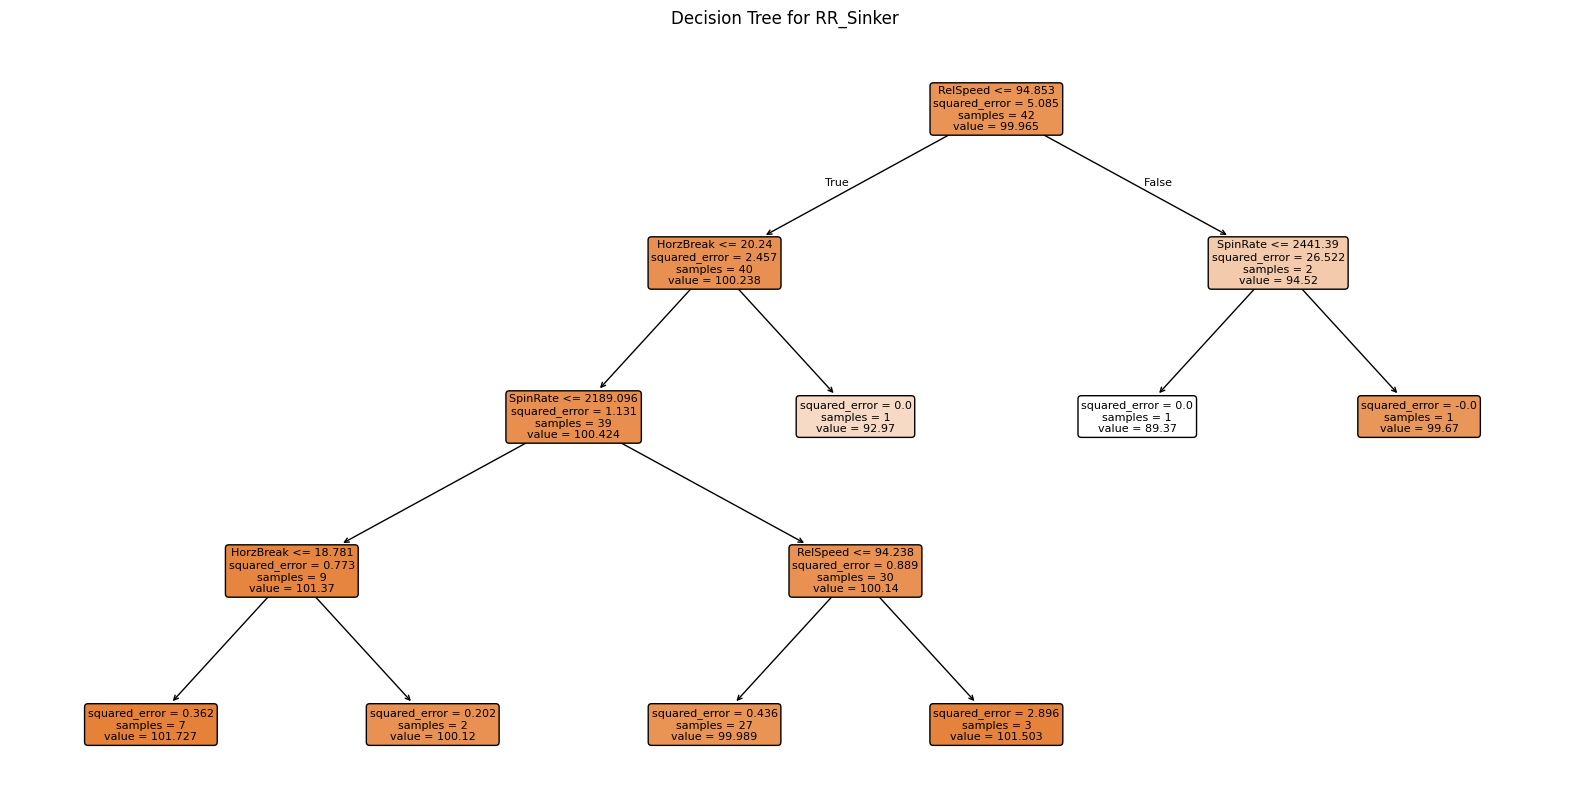

Processing RL_Fastball...


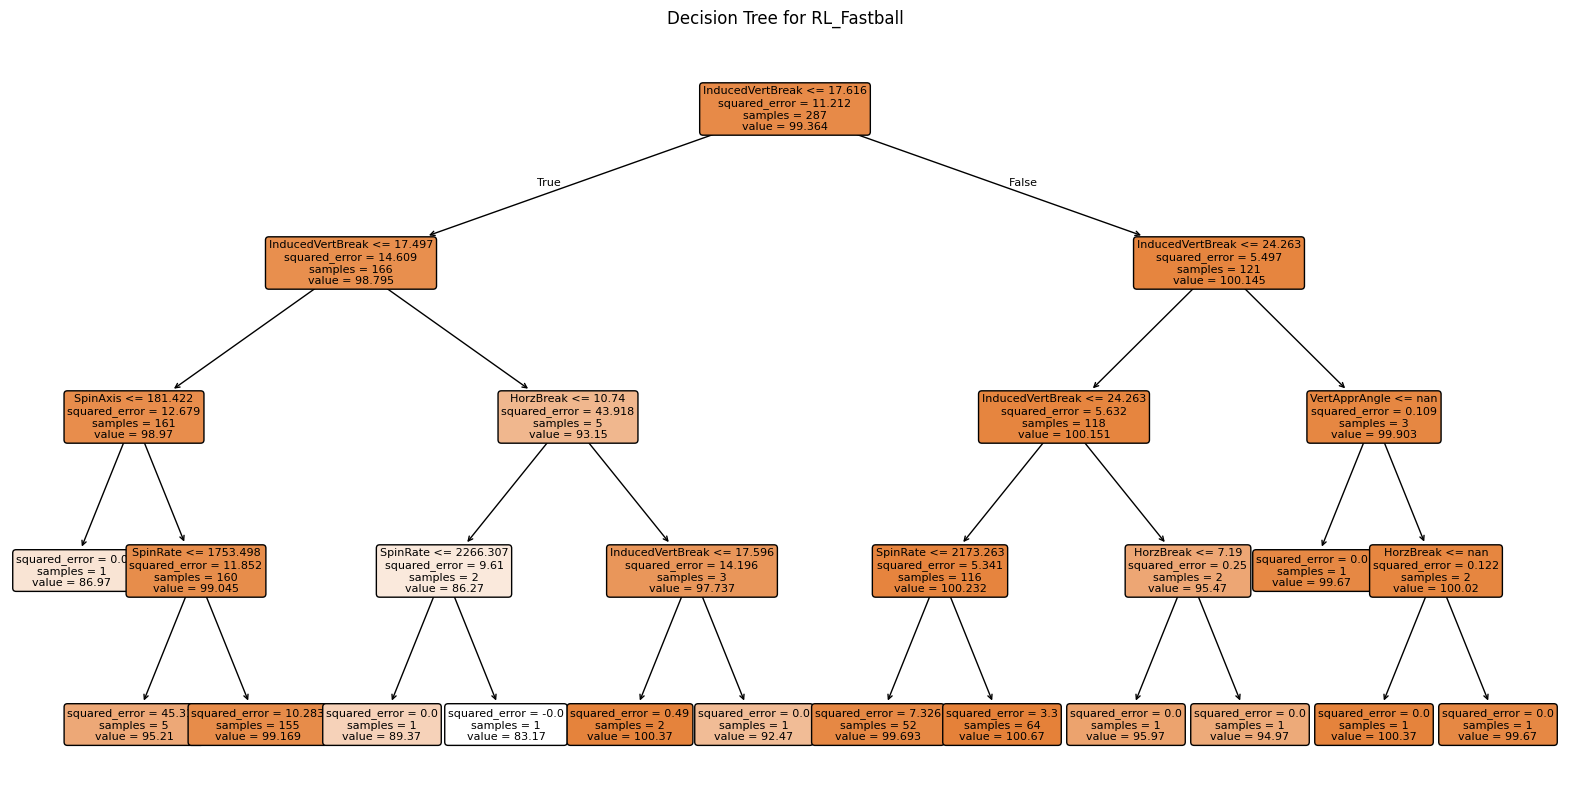

Processing RL_Slider...


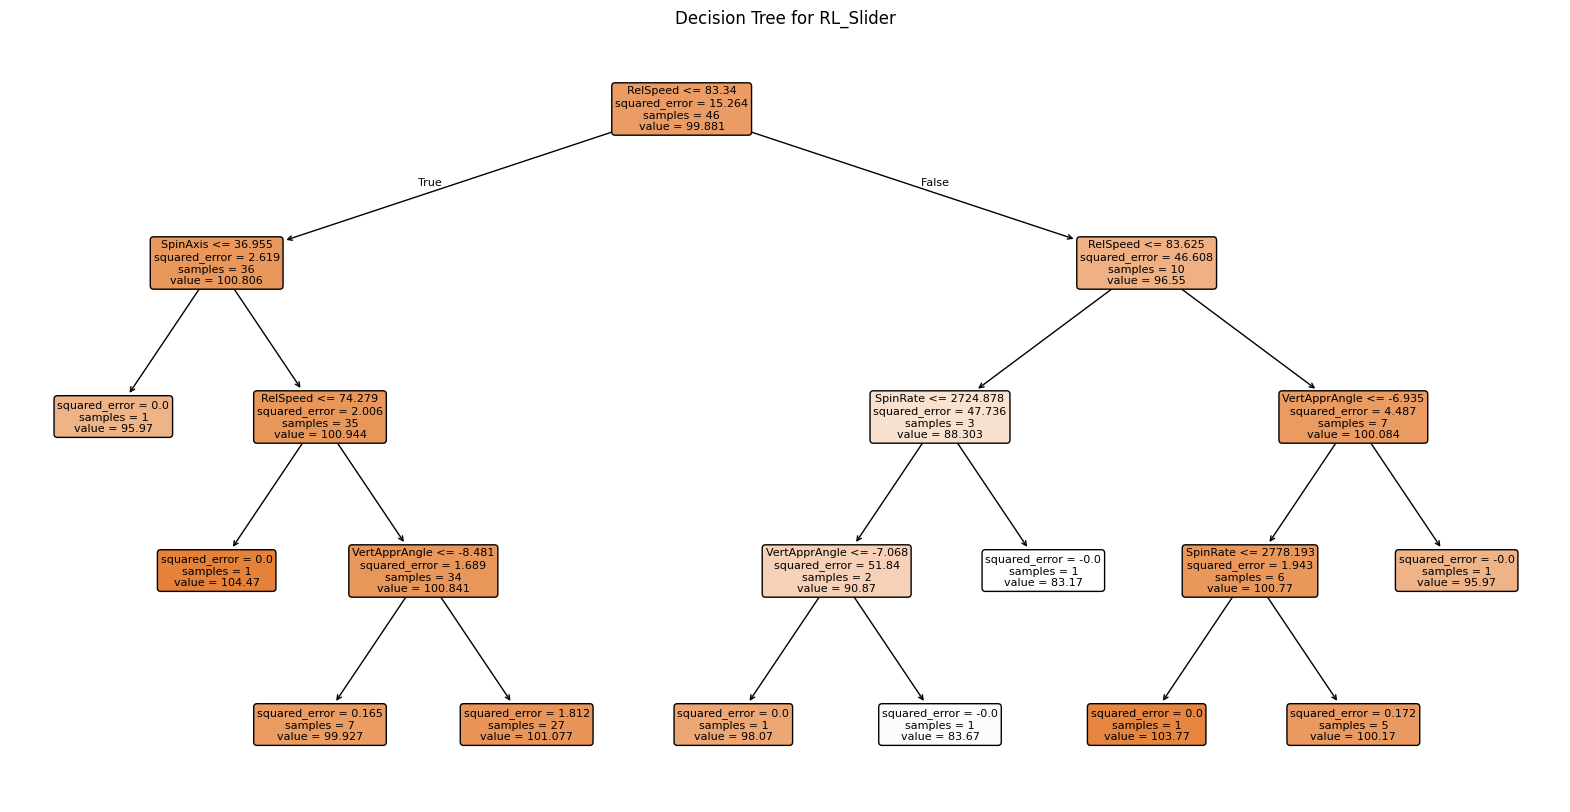

Processing RL_Changeup...


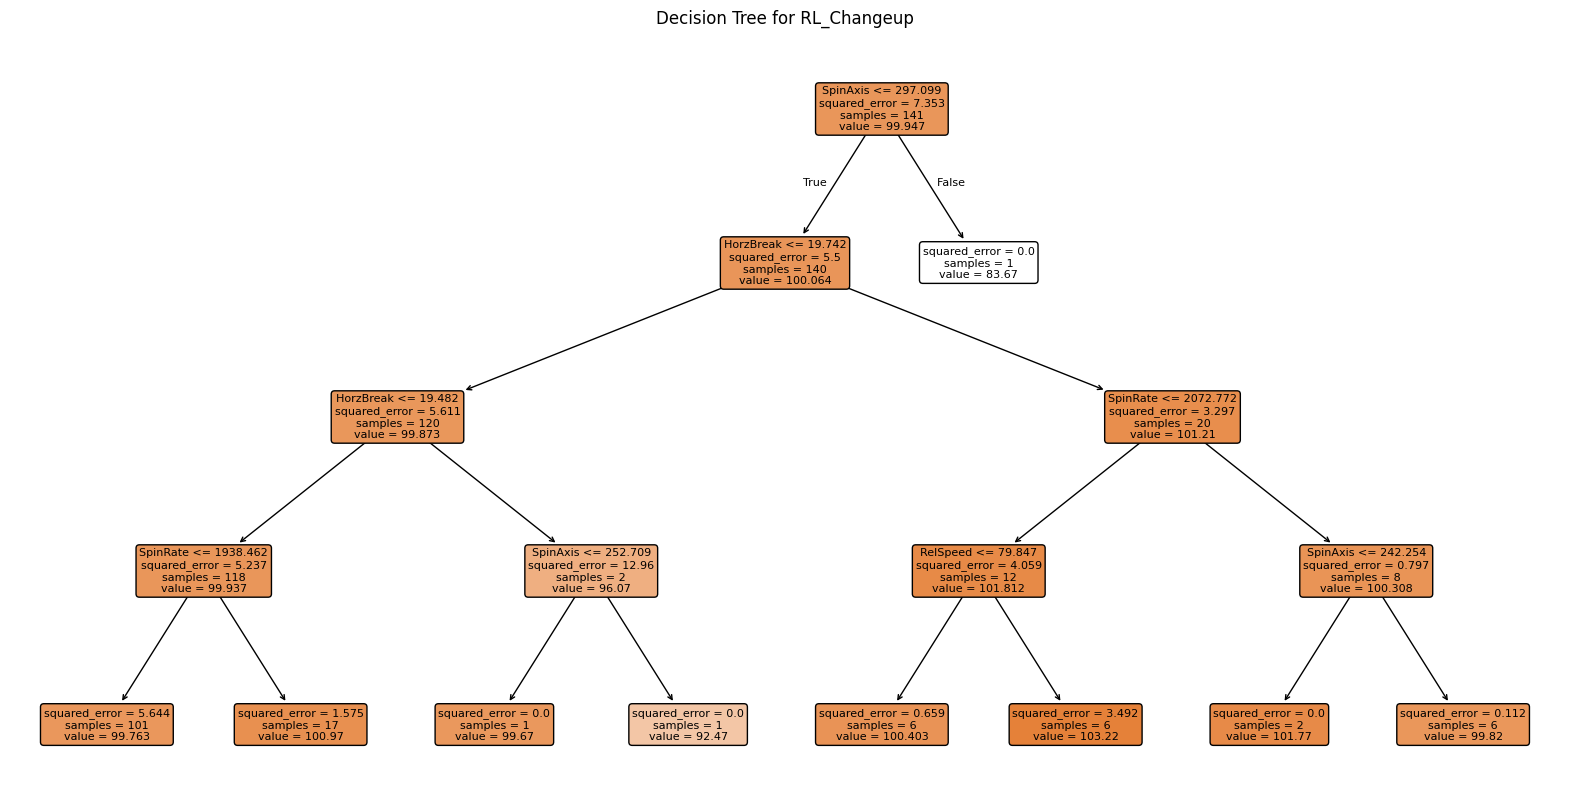

Processing RL_Curveball...


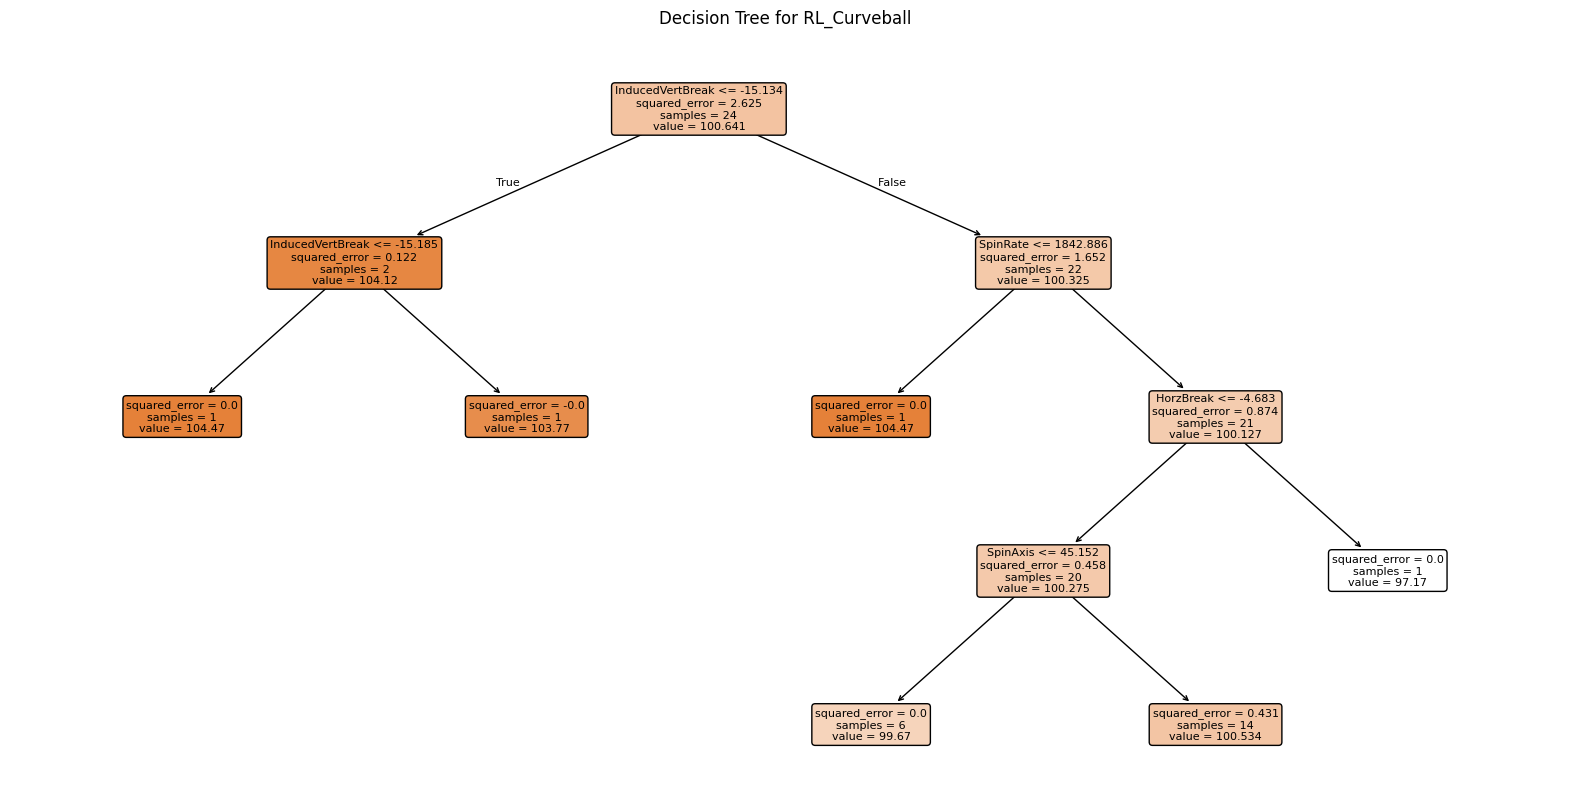

Processing RL_Sinker...


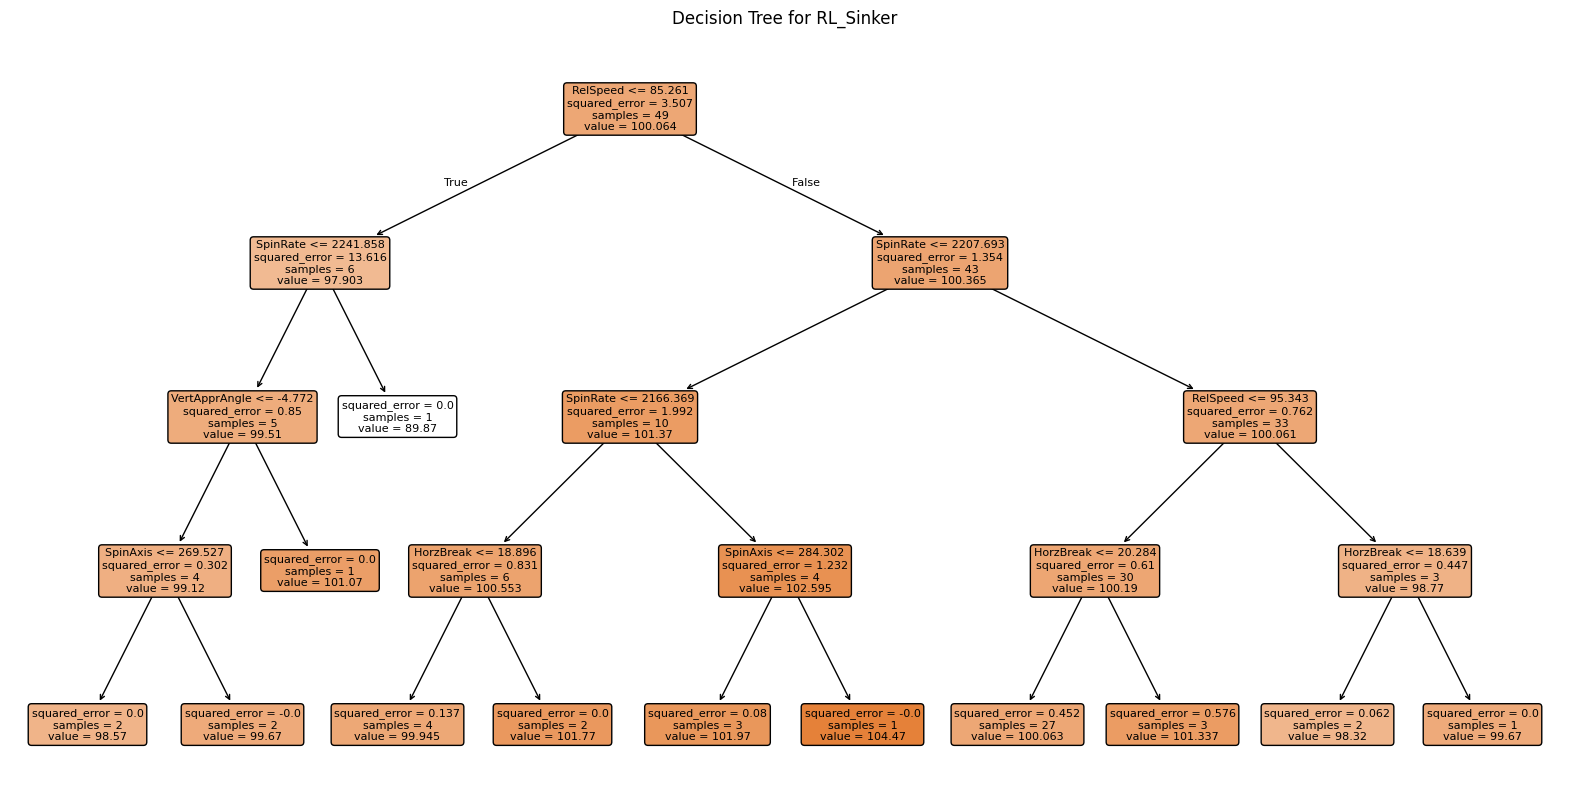

Processing LR_Fastball...


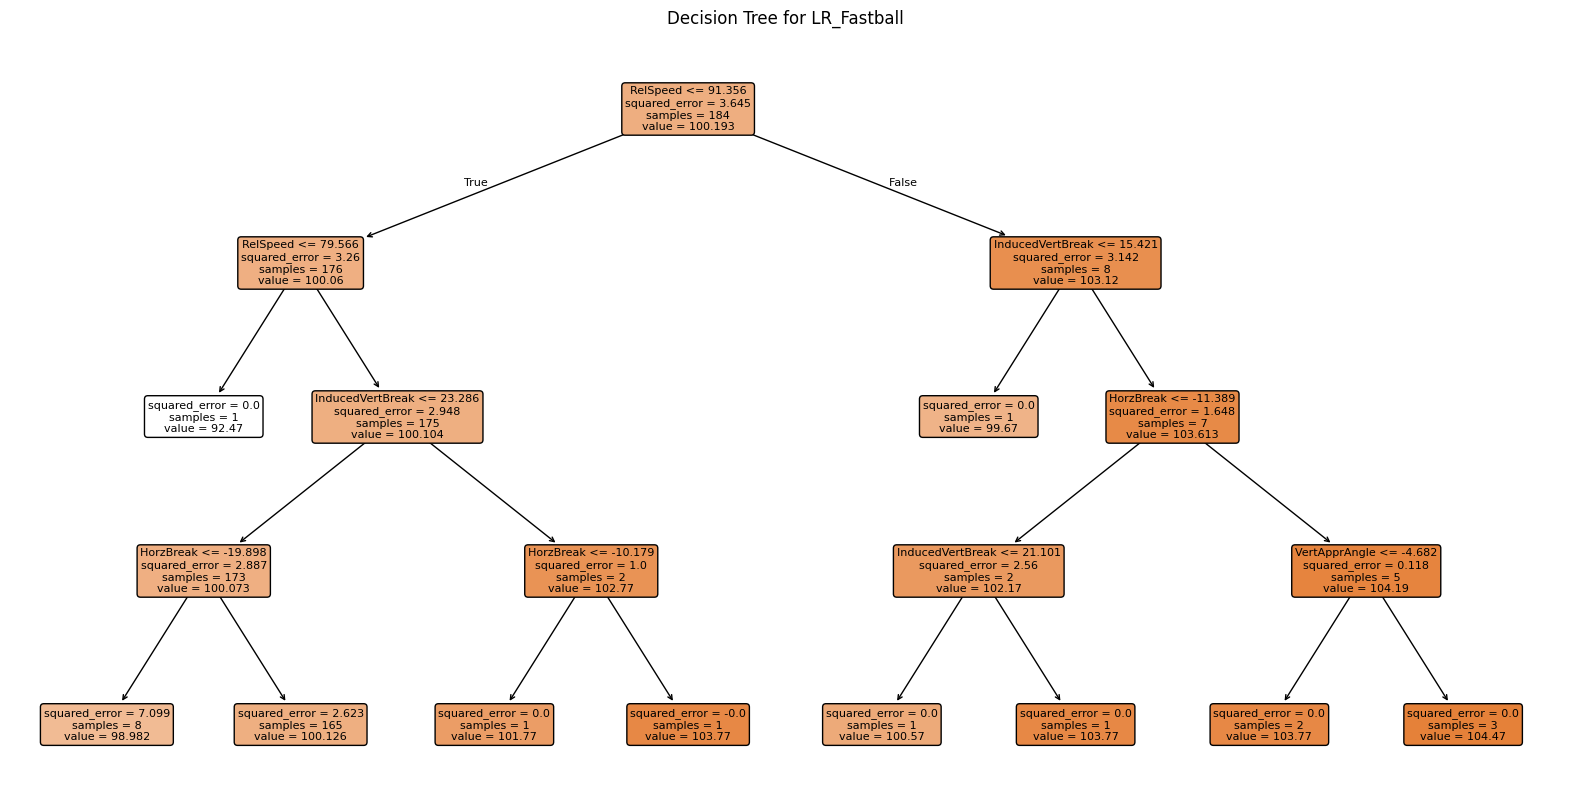

Processing LR_Changeup...


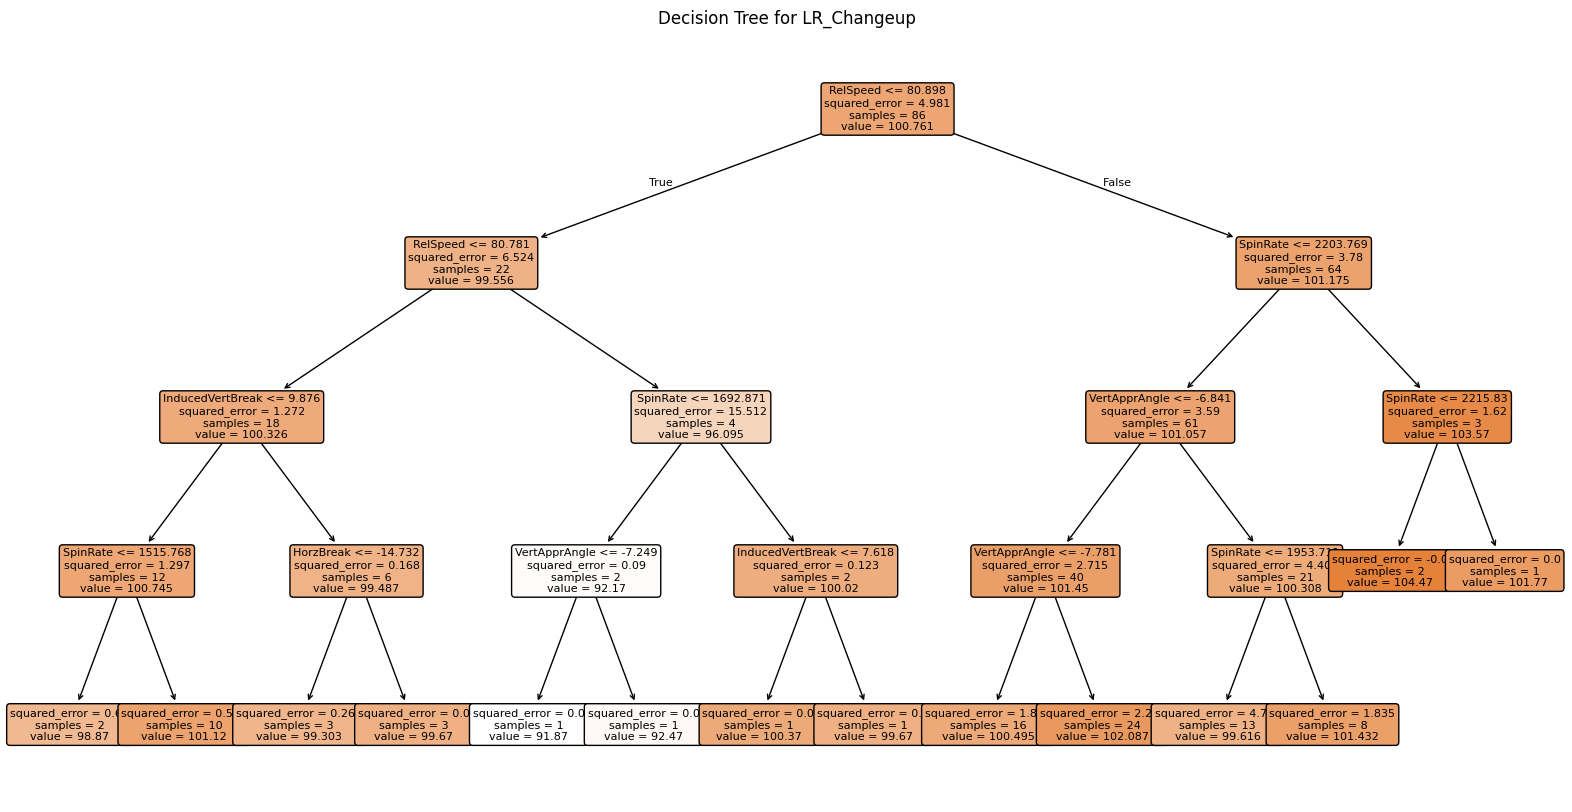

Processing LR_Curveball...


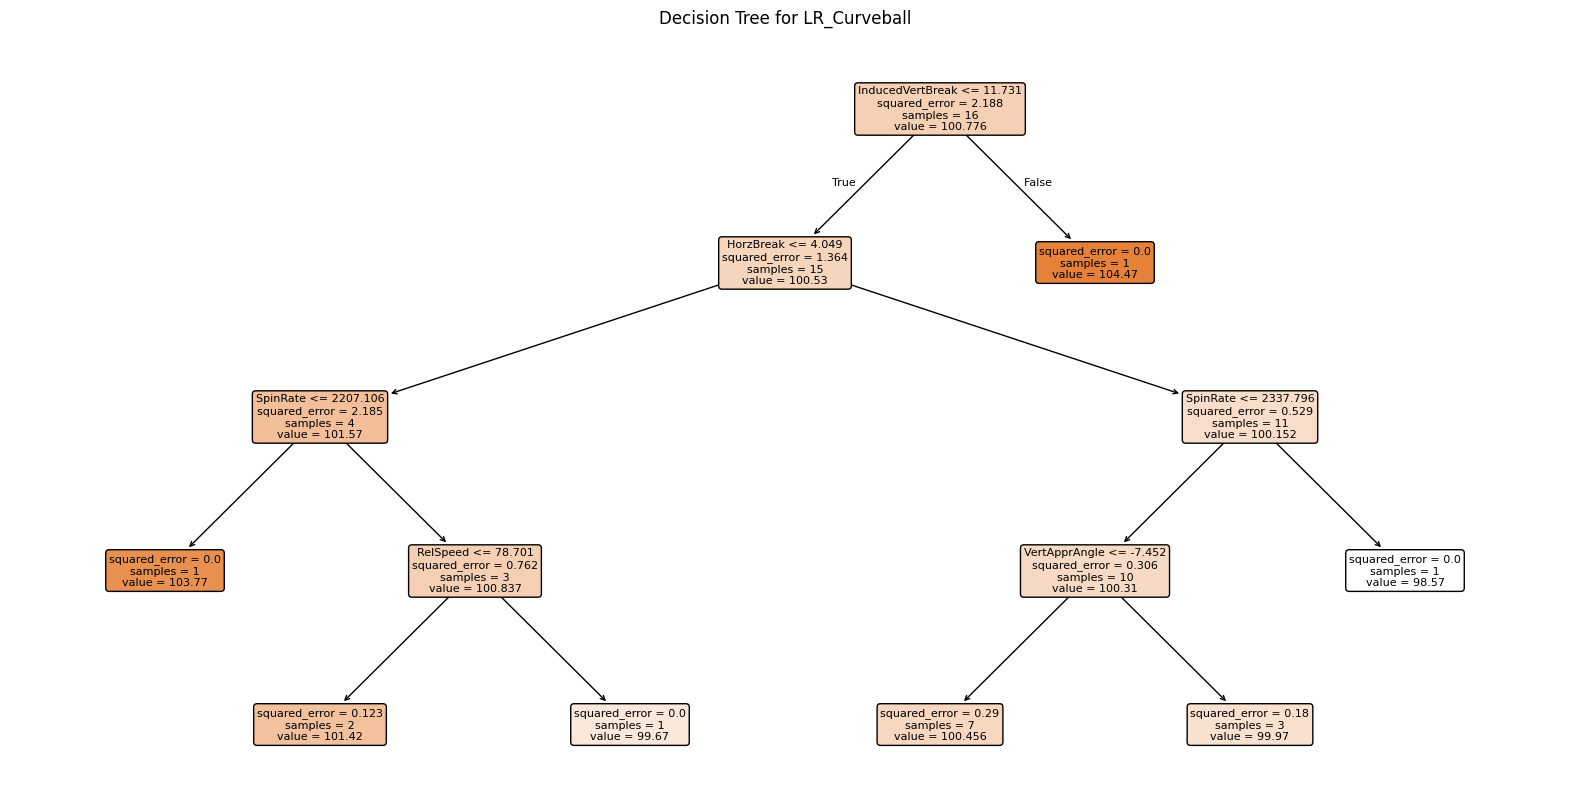

Processing LL_Fastball...


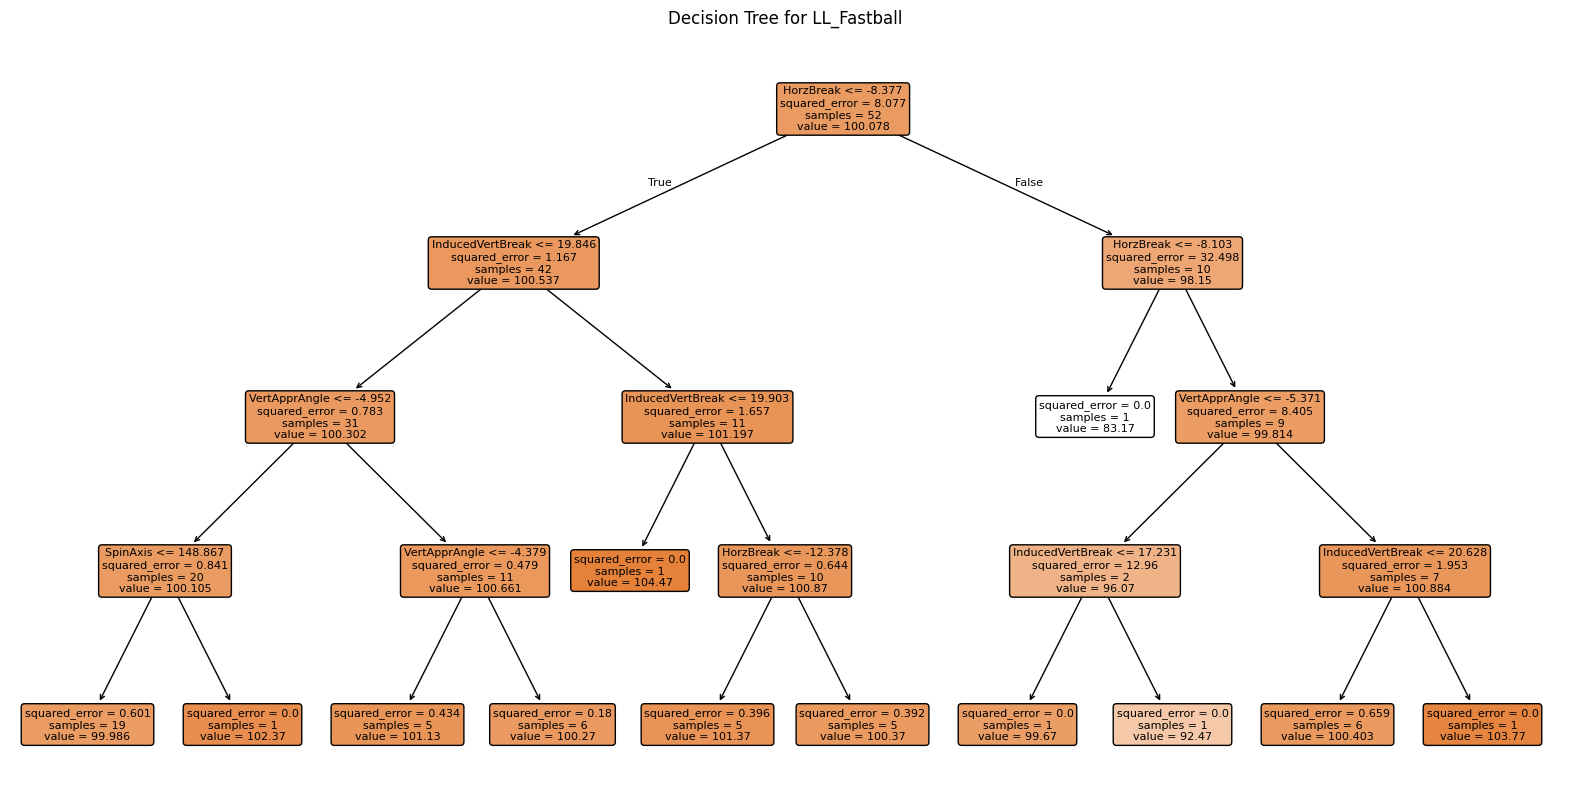

Processing LL_Slider...


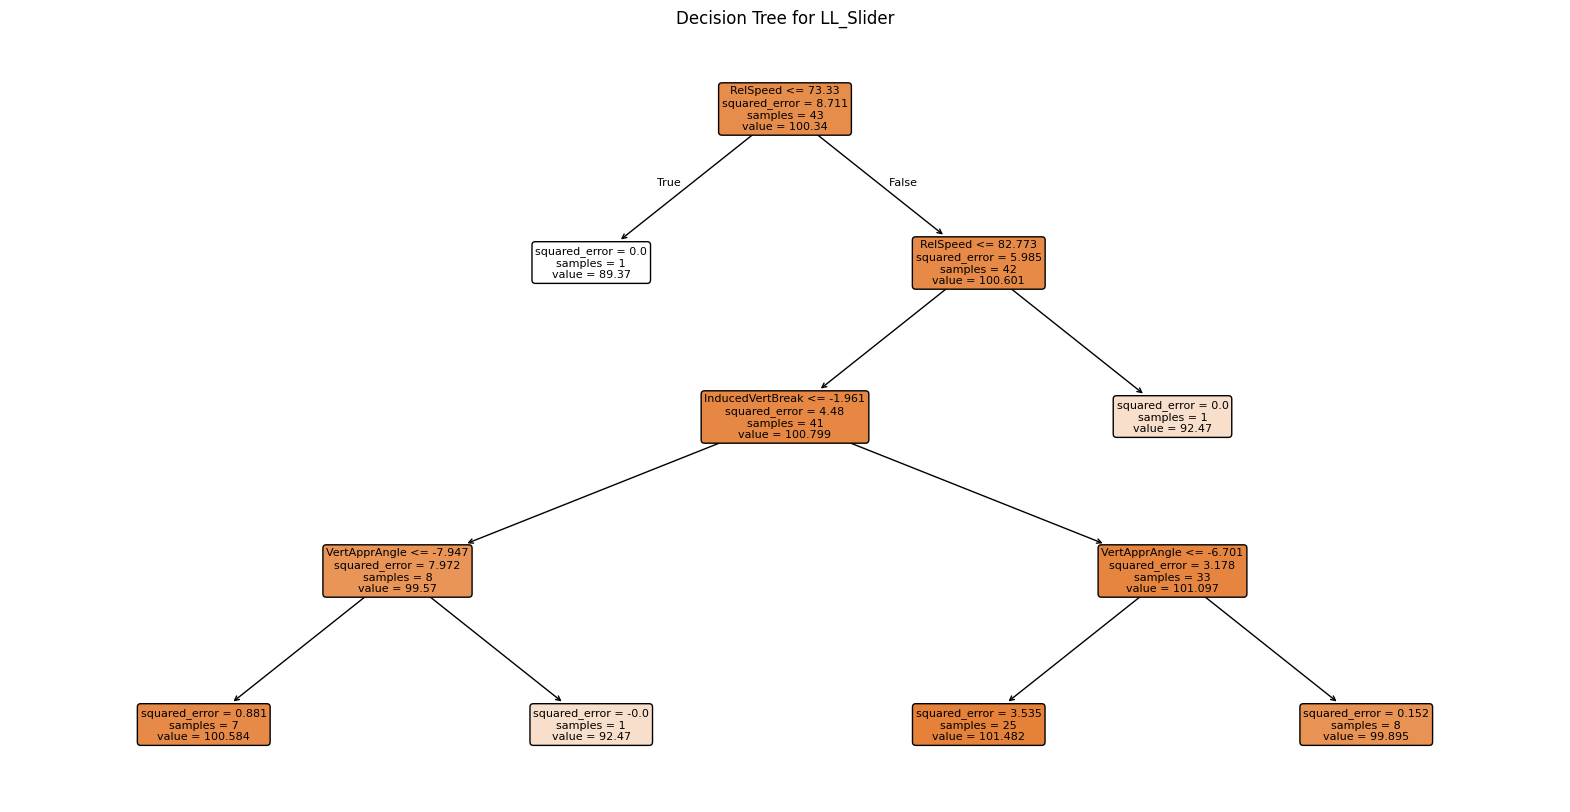

In [20]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Loop through each DataFrame in the subset_dfs dictionary
for df_name, df in subset_dfs.items():
    print(f"Processing {df_name}...")

    # Features
    X = df[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle']]

    # Target
    y = df['StandardizedPES']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create the decision tree regressor with the desired structure
    uva_dt = DecisionTreeRegressor(
        random_state=42,
        max_depth=4,
        criterion='squared_error'
    )

    # Train the model
    uva_dt.fit(X_train, y_train)

    # Visualize the decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(uva_dt, feature_names=X.columns, filled=True, rounded=True, fontsize=8)
    plt.title(f"Decision Tree for {df_name}")
    plt.show()

In [21]:
def get_pitch_recommendation(pitch_type, rel_speed, spin_rate, spin_axis, ivb, hb, vaa):

    """
    Provides the predicted StandardizedPES and the optimal pitch frequency for a given pitch type and pitch characteristics.

    Parameters:
    pitch_type (str): The type of pitch, e.g. "LR_Changeup"
    rel_speed (float): The relative speed of the pitch
    spin_rate (float): The spin rate of the pitch
    spin_axis (float): The spin axis of the pitch
    ivb (float): The induced vertical break of the pitch
    hb (float): The horizontal break of the pitch
    va (float): The vertical approach angle of the pitch

    Returns:
    tuple: (predicted_pes, optimal_frequency)
        predicted_pes (float): The predicted StandardizedPES for the given pitch
        optimal_frequency (float): The recommended frequency (percentage) at which the pitcher should throw this pitch
    """

    # Check if the pitch_type is present in the subset_dfs dictionary
    if pitch_type in subset_dfs:
        df = subset_dfs[pitch_type]

        # Features
        X = df[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle']]

        # Create a new row with the user-provided pitch characteristics
        new_pitch = pd.DataFrame({
            'RelSpeed': [rel_speed],
            'SpinRate': [spin_rate],
            'SpinAxis': [spin_axis],
            'InducedVertBreak': [ivb],
            'HorzBreak': [hb],
            'VertApprAngle': [vaa]
        })

        # Create the decision tree regressor model
        uva_dt = DecisionTreeRegressor(
            random_state=42,
            max_depth=4,
            criterion='squared_error'
        )

        # Train the model
        uva_dt.fit(X, df['StandardizedPES'])

        # Make the prediction for the new pitch
        predicted_pes = uva_dt.predict(new_pitch)[0]

        return predicted_pes
    else:
        return None, None

In [22]:
# Example
pitch_type = "LR_Changeup"
rel_speed = 80.2
spin_rate = 1720.0
spin_axis = 110.3
ivb = 7.8
hb = -12.4
va = -7.3

predicted_pes = get_pitch_recommendation(pitch_type, rel_speed, spin_rate, spin_axis, ivb, hb, va)

print(f"With the given {pitch_type} the predicted StandardizedPES is: {predicted_pes:.2f}")

With the given LR_Changeup the predicted StandardizedPES is: 100.28
